Load the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 1. Load the data



In [ ]:
df = pd.read_csv('GH_5000_Preprocessed.csv')
df

,Sample_code,date_of_collection,Sex,Age,IGF1_mean,P3NP_mean,GH2000_score,Athlete_Id,Haemolysed
0,399445,2020-02-19,M,29,34.39,3.67,1.04,UKAD-2025-1195,False
1,653198,2020-08-22,F,29,174.09,3.71,3.54,UKAD-2025-1197,False
2,652422,2020-08-22,M,26,183.20,3.98,4.44,UKAD-2025-751,False
3,652622,2020-08-27,M,24,228.07,3.29,4.06,UKAD-2025-2402,False
4,652627,2020-08-27,M,28,133.40,3.33,3.49,UKAD-2025-1946,False
...,...,...,...,...,...,...,...,...,...
3893,5805739,2020-10-02,F,32,183.71,2.38,2.81,UKAD-2025-898,False
3894,8146919,2020-10-02,M,27,189.41,3.25,4.04,UKAD-2025-709,False
3895,8146972,2020-10-02,M,25,296.76,4.47,5.65,UKAD-2025-911,False
3896,8146974,2020-10-02,M,32,100.16,3.35,3.28,UKAD-2025-1775,False


# 2. Feature Engineering

For intra-individual variance

In [ ]:
# Count number of samples per athlete
athlete_counts = df.groupby("Athlete_Id").size().reset_index(name="num_samples")

# Filter athletes with 2 or more samples
valid_athletes = athlete_counts[athlete_counts["num_samples"] >= 3]["Athlete_Id"]
df_filtered = df[df["Athlete_Id"].isin(valid_athletes)]
df_filtered = df_filtered[df_filtered["Haemolysed"] != True].copy() #Remove Haemolysed values as they are unreliable


df_stats = df_filtered.groupby("Athlete_Id").agg(
    mean_IGF1 = ("IGF1_mean", "mean"), sd_IGF1 = ("IGF1_mean", "std"),
    mean_P3NP = ("P3NP_mean", "mean"), sd_P3NP = ("P3NP_mean", "std"),
    mean_GH2000 = ("GH2000_score", "mean"), sd_GH2000 = ("GH2000_score", "std"),
    max_GH2000=("GH2000_score", "max"),
    min_GH2000=("GH2000_score","min"),
    max_IGF1 = ("IGF1_mean", "max"),
    min_IGF1 = ("IGF1_mean", "min"),
    max_P3NP = ("P3NP_mean", "max"),
    min_P3NP = ("P3NP_mean", "min"),
    Age = ("Age", "first"),
    Sex = ("Sex","first")# Age for reference
).reset_index()

df_stats["Sex"] = df_stats["Sex"].astype("category").cat.codes #Make the values numeric 0 - F; 1 - M
df_stats


,Athlete_Id,mean_IGF1,sd_IGF1,mean_P3NP,sd_P3NP,mean_GH2000,sd_GH2000,max_GH2000,min_GH2000,max_IGF1,min_IGF1,max_P3NP,min_P3NP,Age,Sex
0,UKAD-2025-1,240.526667,56.361419,3.123333,0.782832,3.360000,1.124758,4.66,1.64,317.18,175.13,4.17,2.22,23,0
1,UKAD-2025-1009,150.727500,36.014756,4.240000,1.252810,4.157500,1.263524,5.27,2.65,191.27,105.98,5.48,2.94,26,1
2,UKAD-2025-1031,214.156667,43.914786,5.853333,1.486248,5.696667,1.140365,6.37,4.38,252.78,166.39,7.02,4.18,25,1
3,UKAD-2025-1037,102.637500,27.795721,2.560000,0.710258,2.502500,0.903489,3.67,1.58,139.79,76.06,3.56,1.90,30,1
4,UKAD-2025-1039,166.280000,89.605074,5.236667,0.579339,4.840000,0.763937,5.44,3.98,268.35,100.57,5.90,4.83,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,UKAD-2025-923,216.050000,47.540022,7.180000,0.686076,6.306667,0.895340,7.27,5.50,270.72,184.42,7.96,6.67,23,1
266,UKAD-2025-940,222.595000,41.203112,2.740000,0.410122,3.010000,0.622254,3.45,2.57,251.73,193.46,3.03,2.45,25,0
267,UKAD-2025-944,282.000000,79.030349,3.253333,0.924356,3.743333,1.157641,4.97,2.67,371.84,223.21,3.97,2.21,25,0
268,UKAD-2025-950,184.830000,7.637153,4.246667,0.866045,4.540000,0.840714,5.36,3.68,193.28,178.42,5.24,3.65,23,1


Add Cofficient of Variation for standardization

In [ ]:
df_stats["CV_IGF1"] = df_stats["sd_IGF1"] / df_stats["mean_IGF1"]
df_stats["CV_P3NP"] = df_stats["sd_P3NP"] / df_stats["mean_P3NP"]
df_stats["CV_GH2000"] = df_stats["sd_GH2000"] / df_stats["mean_GH2000"]

# Calculate number of samples per athlete



Standartize and scale the features

The model appears to be biased towards flagging female athletes, as it does not account for their havign a naturally higher variance. To account for that, we will recalibrate the model, by scaling the different sexes separately


In [ ]:
from sklearn.preprocessing import StandardScaler

# Define features (Athlete_Id is NOT included)
features = ["mean_IGF1", "mean_P3NP", "mean_GH2000", "CV_IGF1", "CV_P3NP", "CV_GH2000", "max_GH2000","min_GH2000", "max_IGF1","min_IGF1","max_P3NP","min_P3NP"]

# Split into male and female
df_male = df_stats[df_stats["Sex"] == 1].copy()
df_female = df_stats[df_stats["Sex"] == 0].copy()

# Scale separately
scaler_male = StandardScaler()
scaler_female = StandardScaler()

df_male_scaled = pd.DataFrame(scaler_male.fit_transform(df_male[features]), columns=features, index=df_male.index)
df_female_scaled = pd.DataFrame(scaler_female.fit_transform(df_female[features]), columns=features, index=df_female.index)

# Merge back while preserving original order
df_scaled = pd.concat([df_male_scaled, df_female_scaled]).sort_index()

In [ ]:
#features = ["mean_IGF1", "mean_P3NP", "mean_GH2000", "CV_IGF1", "CV_P3NP", "CV_GH2000", "Sex"]
#scaler = StandardScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df_stats[features]), columns=features)
#df_scaled

In [ ]:
df_scaled

,mean_IGF1,mean_P3NP,mean_GH2000,CV_IGF1,CV_P3NP,CV_GH2000,max_GH2000,min_GH2000,max_IGF1,min_IGF1,max_P3NP,min_P3NP
0,0.090603,-1.592862,-0.844668,-0.056579,-0.198433,0.421790,-0.592801,-1.221176,0.159789,-0.060646,-1.307333,-1.298122
1,-0.846886,-0.418889,-0.749407,0.379064,0.653755,1.131212,-0.481270,-1.205762,-0.692638,-1.073404,-0.284016,-0.679871
2,0.258972,0.803145,0.801835,0.019342,0.270816,0.160687,0.542592,0.339288,0.137284,0.180912,0.588018,0.368916
3,-1.685313,-1.691419,-2.417390,0.717494,0.487626,1.665627,-1.970523,-2.161371,-1.387230,-1.694644,-1.371228,-1.559498
4,-0.575735,0.336045,-0.061552,3.563665,-1.049441,-0.235473,-0.323037,-0.017949,0.347362,-1.185734,-0.046189,0.918684
...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.291982,1.808040,1.416620,0.178419,-1.188369,-0.383962,1.380297,1.339551,0.379339,0.555276,1.120299,2.474948
266,-0.127006,-1.976603,-1.222362,-0.462703,-1.023577,-0.360816,-1.862340,-0.392203,-0.416001,0.203421,-2.042488,-1.036220
267,0.593903,-1.462723,-0.431002,0.322341,0.075242,0.265934,-0.267547,-0.303066,0.640654,0.632007,-1.436308,-1.309509
268,-0.252325,-0.413839,-0.363906,-1.719146,-0.189711,0.020329,-0.397499,-0.285877,-0.665518,0.430696,-0.419918,-0.079356


# 3. Anomaly Detection Models

Isolation Forest

IsoForest_Scores 1 - normal, -1 - anomaly
IsoForest_Anomaly_score, lower score - more anomalous

In [ ]:
iso_forest = IsolationForest(contamination=0.05, random_state=42) # Define the model
iso_forest.fit(df_scaled) # Fit to the data
df_stats['IsoForest_Scores'] = iso_forest.predict(df_scaled) #Define anomalies

In [ ]:
df_stats["IsoForest_Anomaly_Score"] = iso_forest.decision_function(df_scaled) #Anomaly scores instead of binary values
df_stats

,Athlete_Id,mean_IGF1,sd_IGF1,mean_P3NP,sd_P3NP,mean_GH2000,sd_GH2000,max_GH2000,min_GH2000,max_IGF1,min_IGF1,max_P3NP,min_P3NP,Age,Sex,CV_IGF1,CV_P3NP,CV_GH2000,IsoForest_Scores,IsoForest_Anomaly_Score
0,UKAD-2025-1,240.526667,56.361419,3.123333,0.782832,3.360000,1.124758,4.66,1.64,317.18,175.13,4.17,2.22,23,0,0.234325,0.250640,0.334749,1,0.120822
1,UKAD-2025-1009,150.727500,36.014756,4.240000,1.252810,4.157500,1.263524,5.27,2.65,191.27,105.98,5.48,2.94,26,1,0.238940,0.295474,0.303914,1,0.144219
2,UKAD-2025-1031,214.156667,43.914786,5.853333,1.486248,5.696667,1.140365,6.37,4.38,252.78,166.39,7.02,4.18,25,1,0.205059,0.253915,0.200181,1,0.154788
3,UKAD-2025-1037,102.637500,27.795721,2.560000,0.710258,2.502500,0.903489,3.67,1.58,139.79,76.06,3.56,1.90,30,1,0.270814,0.277445,0.361034,1,0.016452
4,UKAD-2025-1039,166.280000,89.605074,5.236667,0.579339,4.840000,0.763937,5.44,3.98,268.35,100.57,5.90,4.83,23,1,0.538881,0.110631,0.157838,1,0.078371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,UKAD-2025-923,216.050000,47.540022,7.180000,0.686076,6.306667,0.895340,7.27,5.50,270.72,184.42,7.96,6.67,23,1,0.220042,0.095554,0.141967,1,0.086922
266,UKAD-2025-940,222.595000,41.203112,2.740000,0.410122,3.010000,0.622254,3.45,2.57,251.73,193.46,3.03,2.45,25,0,0.185103,0.149680,0.206729,1,0.052714
267,UKAD-2025-944,282.000000,79.030349,3.253333,0.924356,3.743333,1.157641,4.97,2.67,371.84,223.21,3.97,2.21,25,0,0.280249,0.284126,0.309254,1,0.116178
268,UKAD-2025-950,184.830000,7.637153,4.246667,0.866045,4.540000,0.840714,5.36,3.68,193.28,178.42,5.24,3.65,23,1,0.041320,0.203935,0.185179,1,0.128871


In [ ]:
IsoForest_anomalies = df_stats[df_stats["IsoForest_Scores"] == -1]
IsoForest_anomalies #2025-193 included

,Athlete_Id,mean_IGF1,sd_IGF1,mean_P3NP,sd_P3NP,mean_GH2000,sd_GH2000,max_GH2000,min_GH2000,max_IGF1,min_IGF1,max_P3NP,min_P3NP,Age,Sex,CV_IGF1,CV_P3NP,CV_GH2000,IsoForest_Scores,IsoForest_Anomaly_Score
7,UKAD-2025-1049,288.666667,90.160242,8.160000,1.178474,6.693333,0.961110,7.68,5.76,385.90,207.83,9.44,7.12,21,1,0.312333,0.144421,0.143592,-1,-0.005420
39,UKAD-2025-1318,518.193333,140.122772,4.616667,1.542930,5.780000,1.306637,6.89,4.34,679.76,429.89,5.62,2.84,23,0,0.270406,0.334209,0.226062,-1,-0.032268
80,UKAD-2025-1661,140.363333,28.446382,2.100000,0.085440,2.773333,0.293995,3.10,2.53,173.16,122.39,2.18,2.01,33,1,0.202662,0.040686,0.106008,-1,-0.028697
98,UKAD-2025-1822,132.846667,37.276663,4.136667,2.182254,3.233333,2.010133,4.69,0.94,170.65,96.12,6.44,2.10,23,1,0.280599,0.527539,0.621691,-1,-0.034963
129,UKAD-2025-2143,317.953333,36.222168,5.323333,0.011547,6.530000,0.495076,6.94,5.98,359.58,293.61,5.33,5.31,24,1,0.113923,0.002169,0.075816,-1,-0.000144
142,UKAD-2025-2244,296.970000,51.015320,8.115000,2.888996,7.292500,0.757072,8.18,6.36,344.47,242.33,12.34,5.80,23,1,0.171786,0.356007,0.103815,-1,-0.041100
148,UKAD-2025-2274,388.166667,135.541011,5.473333,0.907983,5.863333,0.158219,6.00,5.69,504.22,239.20,6.28,4.49,18,1,0.349183,0.165892,0.026985,-1,-0.016018
157,UKAD-2025-2363,377.720000,108.458892,5.350000,3.405011,4.660000,2.611341,6.71,1.72,499.33,291.00,7.79,1.46,21,0,0.287141,0.636451,0.560374,-1,-0.056740
165,UKAD-2025-2419,308.650000,149.477253,8.720000,3.894958,6.546667,2.250363,9.02,4.62,459.22,160.29,13.21,6.25,20,1,0.484294,0.446670,0.343742,-1,-0.117948
178,UKAD-2025-2554,189.453333,96.342891,3.233333,1.792466,3.850000,1.657920,5.72,2.56,284.31,91.69,4.84,1.30,30,1,0.508531,0.554371,0.430629,-1,-0.007080


Autoencoder

Higher reconstruction error - more anomalous

In [ ]:
df_scaled_auto = df_scaled[df_scaled['CV_GH2000'] < 40]

In [ ]:
input_dim = df_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(4, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

#Train Autoencoder

autoencoder.fit(df_scaled_auto,df_scaled,epochs=50,batch_size=16,validation_split=0.2,verbose=0)

# Compute Reconstruction Error
df_stats['Autoencoder_Error'] = np.mean(np.square(df_scaled - autoencoder.predict(df_scaled)), axis=1)

# Set Anomaly Threshold (95th percentile)
threshold = np.percentile(df_stats["Autoencoder_Error"], 95)

# Identify anomalies
df_stats["Autoencoder_Anomaly"] = (df_stats["Autoencoder_Error"] > threshold).astype(int)

# Extract anomalous athletes
AutoEncoders_anomalies = df_stats[df_stats["Autoencoder_Anomaly"].astype(bool)]

print(AutoEncoders_anomalies)

df_stats
#2025-193 is present


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
         Athlete_Id   mean_IGF1     sd_IGF1  mean_P3NP   sd_P3NP  mean_GH2000  \
3    UKAD-2025-1037  102.637500   27.795721   2.560000  0.710258     2.502500   
4    UKAD-2025-1039  166.280000   89.605074   5.236667  0.579339     4.840000   
13   UKAD-2025-1109  182.960000   17.593274   2.360000  0.960625     3.293333   
96   UKAD-2025-1797  130.970000   58.554608   4.260000  0.642573     2.130000   
98   UKAD-2025-1822  132.846667   37.276663   4.136667  2.182254     3.233333   
111   UKAD-2025-193  130.587143   63.964554   3.734286  1.275224     2.610000   
112  UKAD-2025-1933  128.380000   39.711253   2.700000  0.815046     3.163333   
132  UKAD-2025-2173  195.956667   55.741432   2.591667  0.774401     3.063333   
133  UKAD-2025-2181  101.026667   28.615077   4.086667  1.952699     3.413333   
178  UKAD-2025-2554  189.453333   96.342891   3.233333  1.792466     3.850000   
207   UKAD-2025-336  216.133333   73.595126   3.793333  2.567515     2.2

,Athlete_Id,mean_IGF1,sd_IGF1,mean_P3NP,sd_P3NP,mean_GH2000,sd_GH2000,max_GH2000,min_GH2000,max_IGF1,...,min_P3NP,Age,Sex,CV_IGF1,CV_P3NP,CV_GH2000,IsoForest_Scores,IsoForest_Anomaly_Score,Autoencoder_Error,Autoencoder_Anomaly
0,UKAD-2025-1,240.526667,56.361419,3.123333,0.782832,3.360000,1.124758,4.66,1.64,317.18,...,2.22,23,0,0.234325,0.250640,0.334749,1,0.120822,0.371183,0
1,UKAD-2025-1009,150.727500,36.014756,4.240000,1.252810,4.157500,1.263524,5.27,2.65,191.27,...,2.94,26,1,0.238940,0.295474,0.303914,1,0.144219,0.234827,0
2,UKAD-2025-1031,214.156667,43.914786,5.853333,1.486248,5.696667,1.140365,6.37,4.38,252.78,...,4.18,25,1,0.205059,0.253915,0.200181,1,0.154788,0.026427,0
3,UKAD-2025-1037,102.637500,27.795721,2.560000,0.710258,2.502500,0.903489,3.67,1.58,139.79,...,1.90,30,1,0.270814,0.277445,0.361034,1,0.016452,1.877607,1
4,UKAD-2025-1039,166.280000,89.605074,5.236667,0.579339,4.840000,0.763937,5.44,3.98,268.35,...,4.83,23,1,0.538881,0.110631,0.157838,1,0.078371,1.416724,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,UKAD-2025-923,216.050000,47.540022,7.180000,0.686076,6.306667,0.895340,7.27,5.50,270.72,...,6.67,23,1,0.220042,0.095554,0.141967,1,0.086922,0.192680,0
266,UKAD-2025-940,222.595000,41.203112,2.740000,0.410122,3.010000,0.622254,3.45,2.57,251.73,...,2.45,25,0,0.185103,0.149680,0.206729,1,0.052714,0.439023,0
267,UKAD-2025-944,282.000000,79.030349,3.253333,0.924356,3.743333,1.157641,4.97,2.67,371.84,...,2.21,25,0,0.280249,0.284126,0.309254,1,0.116178,0.526680,0
268,UKAD-2025-950,184.830000,7.637153,4.246667,0.866045,4.540000,0.840714,5.36,3.68,193.28,...,3.65,23,1,0.041320,0.203935,0.185179,1,0.128871,0.284571,0


DBSCAN

Plot a K-distance graph to determine the optimal epsilon value

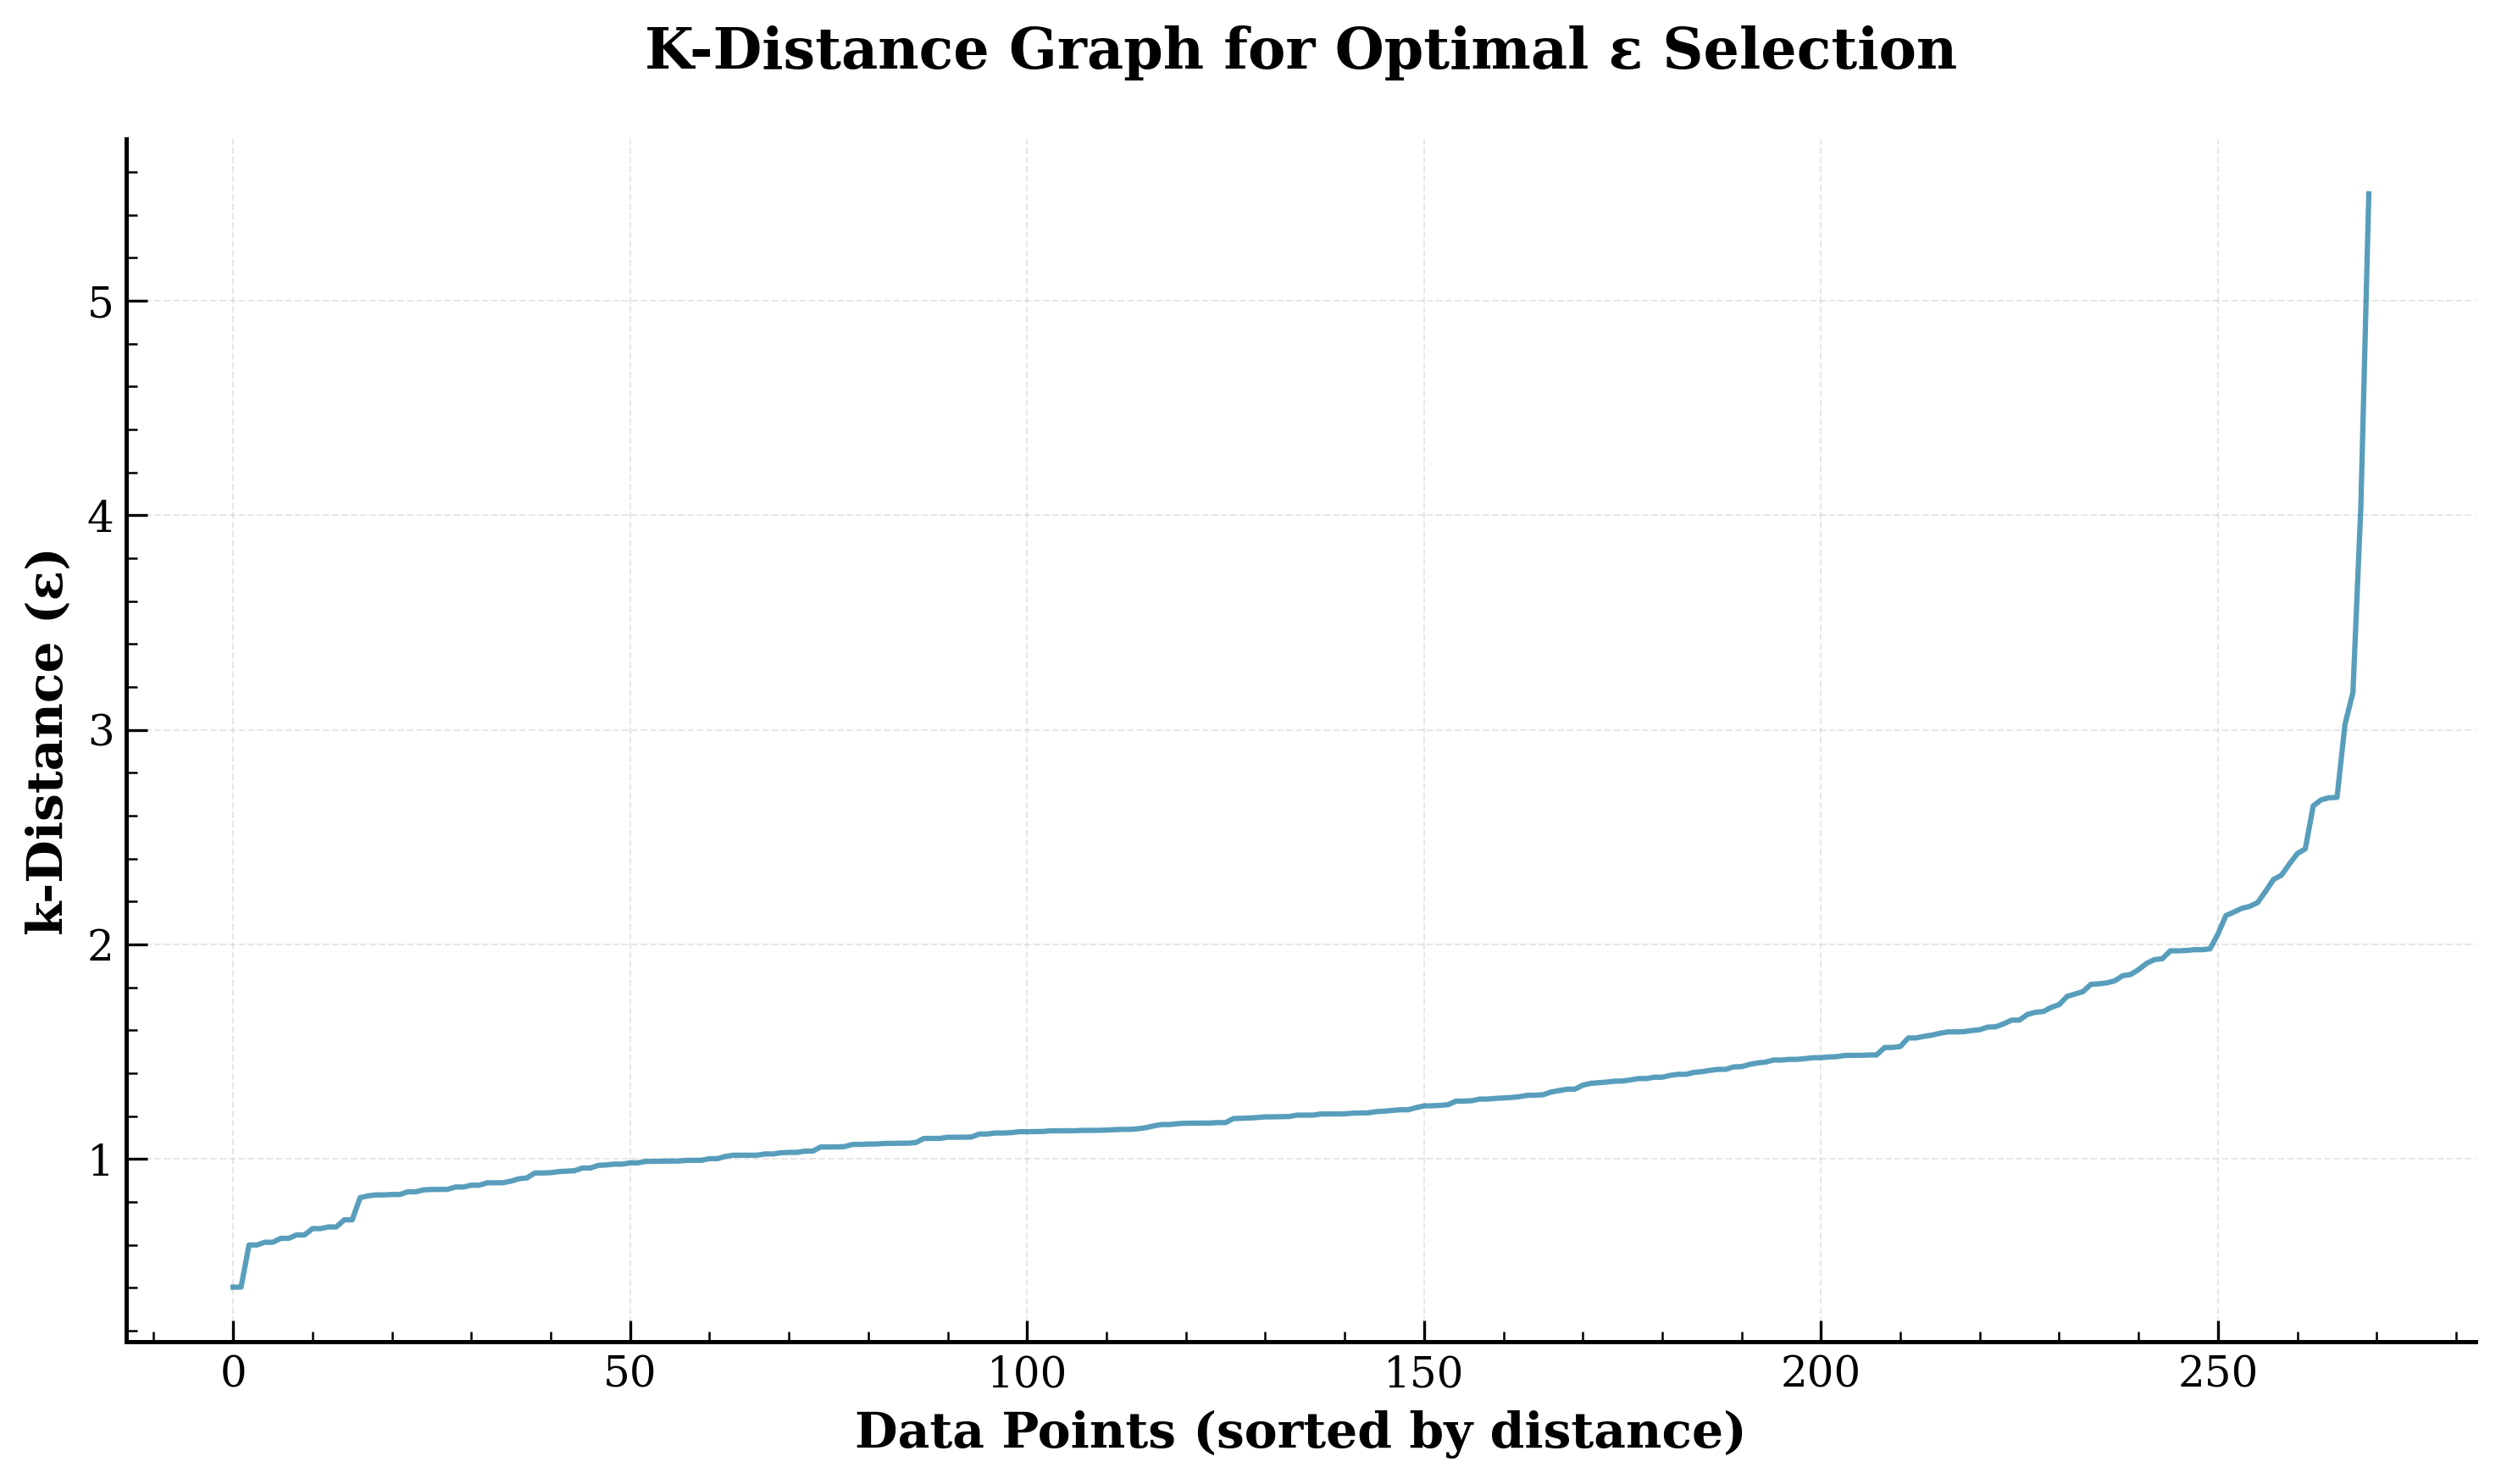

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Set up publication-quality plotting parameters
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
    'legend.frameon': False,
    'figure.dpi': 300
})

# Your existing code for k-distance calculation
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# Create publication-ready plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot with improved styling
ax.plot(distances, linewidth=1.5, color='#2E86AB', alpha=0.8)

# Enhanced title and labels
ax.set_title('K-Distance Graph for Optimal ε Selection',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Data Points (sorted by distance)', fontsize=14, fontweight='semibold')
ax.set_ylabel('k-Distance (ε)', fontsize=14, fontweight='semibold')

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add minor ticks
ax.minorticks_on()

# Optimize layout
plt.tight_layout()

# Optional: Add annotation for elbow point identification
# You can uncomment and modify this section if you want to highlight the elbow
"""
# Find approximate elbow point (this is a simple method, you might want to use a more sophisticated approach)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# Simple elbow detection using second derivative
def find_elbow(distances):
    n_points = len(distances)
    all_coord = np.vstack((range(n_points), distances)).T
    np.array([range(n_points), distances])
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    elbow_idx = np.argmax(dist_to_line)
    return elbow_idx

elbow_idx = find_elbow(distances)
ax.axvline(x=elbow_idx, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax.axhline(y=distances[elbow_idx], color='red', linestyle='--', alpha=0.7, linewidth=2)
ax.plot(elbow_idx, distances[elbow_idx], 'ro', markersize=8, label=f'Elbow point (ε ≈ {distances[elbow_idx]:.3f})')
ax.legend(loc='upper left', fontsize=12)
"""

# Show the plot
plt.show()

# Optional: Save the figure in publication quality
# plt.savefig('k_distance_graph.png', dpi=300, bbox_inches='tight', facecolor='white')
# plt.savefig('k_distance_graph.pdf', bbox_inches='tight', facecolor='white')  # For LaTeX documents

In [ ]:
dbscan = DBSCAN(eps=3,min_samples=40).fit(df_scaled)
df_stats["DBSCAN_Label"] = dbscan.labels_
df_stats["DBSCAN_Anomaly"] = (df_stats["DBSCAN_Label"] == -1).astype(int)

DBSCAN_anomalies = df_stats[df_stats["DBSCAN_Label"] == -1]
DBSCAN_anomalies

,Athlete_Id,mean_IGF1,sd_IGF1,mean_P3NP,sd_P3NP,mean_GH2000,sd_GH2000,max_GH2000,min_GH2000,max_IGF1,...,Sex,CV_IGF1,CV_P3NP,CV_GH2000,IsoForest_Scores,IsoForest_Anomaly_Score,Autoencoder_Error,Autoencoder_Anomaly,DBSCAN_Label,DBSCAN_Anomaly
20,UKAD-2025-1168,245.065000,71.056860,8.335000,1.914306,6.757500,1.087516,7.58,5.22,322.58,...,1,0.289951,0.229671,0.160935,1,0.053002,0.279359,0,-1,1
39,UKAD-2025-1318,518.193333,140.122772,4.616667,1.542930,5.780000,1.306637,6.89,4.34,679.76,...,0,0.270406,0.334209,0.226062,-1,-0.032268,0.735474,0,-1,1
86,UKAD-2025-1723,290.616667,119.272436,7.336667,3.095906,6.040000,2.204291,7.61,3.52,362.58,...,0,0.410412,0.421977,0.364949,1,0.012554,0.315665,0,-1,1
98,UKAD-2025-1822,132.846667,37.276663,4.136667,2.182254,3.233333,2.010133,4.69,0.94,170.65,...,1,0.280599,0.527539,0.621691,-1,-0.034963,2.735917,1,-1,1
142,UKAD-2025-2244,296.970000,51.015320,8.115000,2.888996,7.292500,0.757072,8.18,6.36,344.47,...,1,0.171786,0.356007,0.103815,-1,-0.041100,0.257998,0,-1,1
148,UKAD-2025-2274,388.166667,135.541011,5.473333,0.907983,5.863333,0.158219,6.00,5.69,504.22,...,1,0.349183,0.165892,0.026985,-1,-0.016018,0.670154,0,-1,1
157,UKAD-2025-2363,377.720000,108.458892,5.350000,3.405011,4.660000,2.611341,6.71,1.72,499.33,...,0,0.287141,0.636451,0.560374,-1,-0.056740,1.281545,0,-1,1
165,UKAD-2025-2419,308.650000,149.477253,8.720000,3.894958,6.546667,2.250363,9.02,4.62,459.22,...,1,0.484294,0.446670,0.343742,-1,-0.117948,1.049313,0,-1,1
178,UKAD-2025-2554,189.453333,96.342891,3.233333,1.792466,3.850000,1.657920,5.72,2.56,284.31,...,1,0.508531,0.554371,0.430629,-1,-0.007080,2.759543,1,-1,1
182,UKAD-2025-2590,215.130000,84.699640,5.026667,2.550026,5.783333,2.156324,8.15,3.93,308.32,...,1,0.393714,0.507300,0.372851,1,0.000176,0.829995,0,-1,1


#Compare Model Results

Isolation Forest flagged 14 athletes (5.2%)
Autoencoder flagged 14 athletes (5.2%)
DBSCAN flagged 15 athletes (5.6%)


/tmp/ipython-input-66-2823070952.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


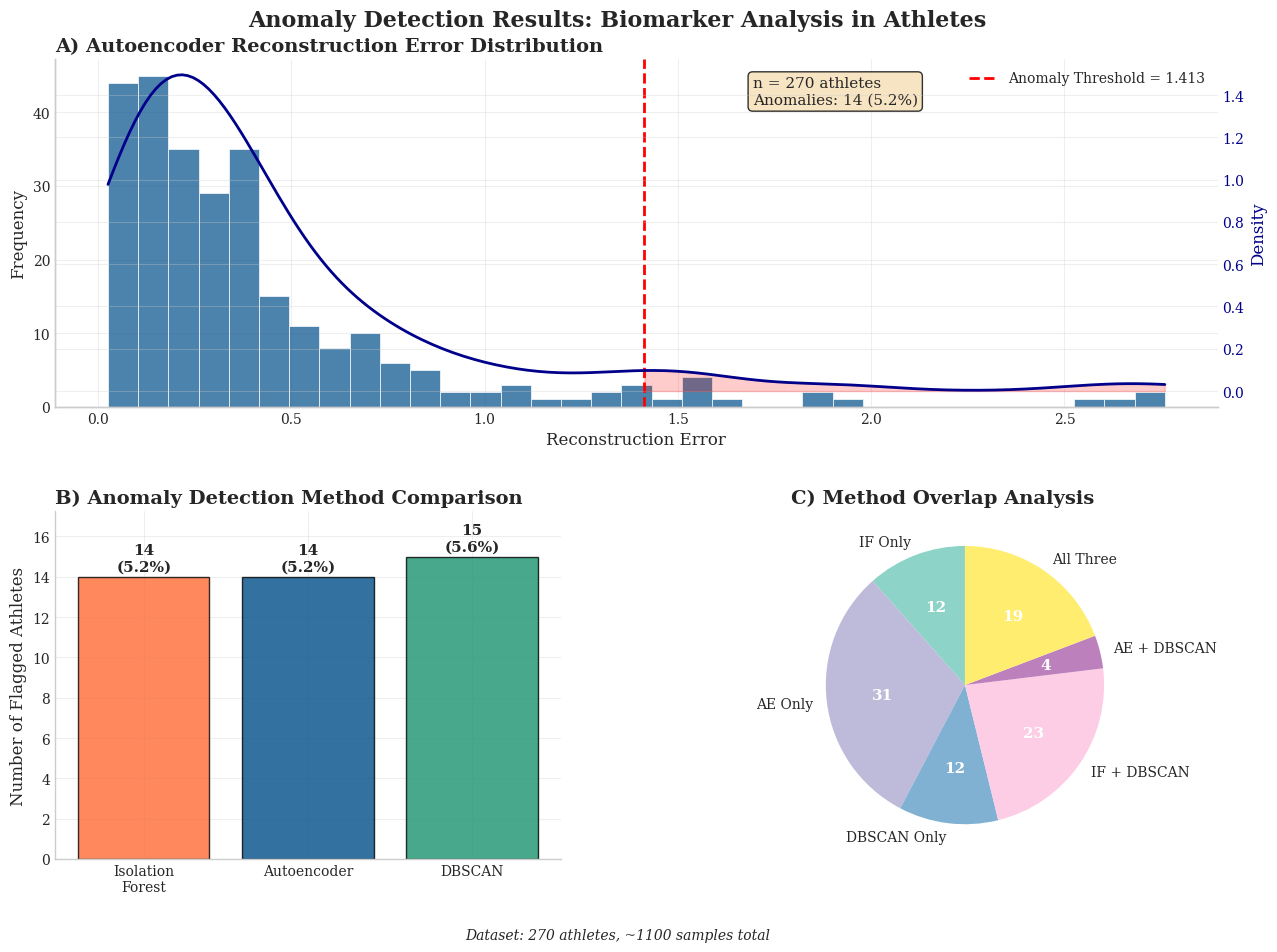

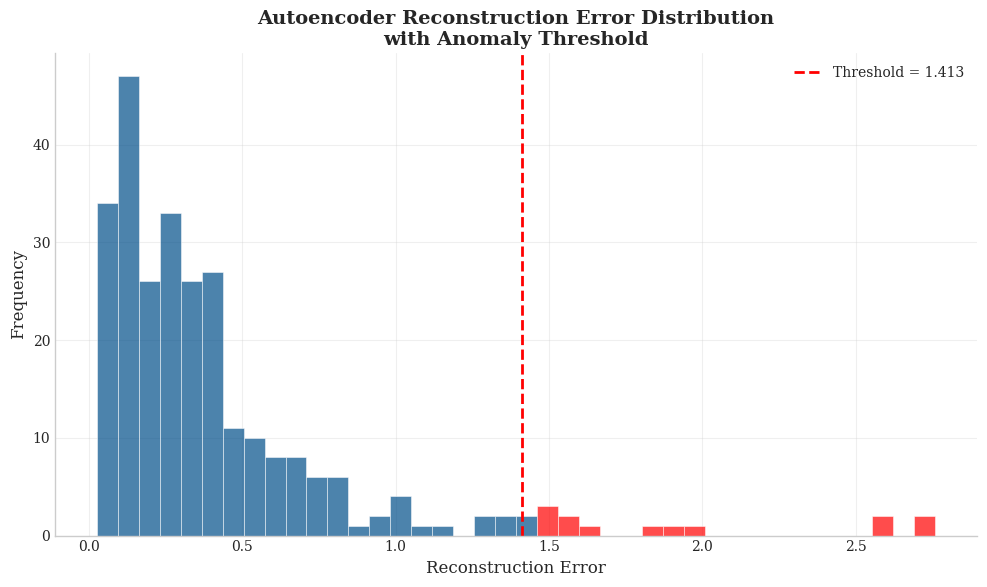


📊 High-quality plots saved as:
- anomaly_detection_results.png (300 DPI)
- anomaly_detection_results.pdf (vector format)
- autoencoder_detailed.png (300 DPI)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Your data preparation (replace with your actual data)
# Count flagged athletes
iso_count = (df_stats["IsoForest_Scores"] == -1).sum()
auto_count = df_stats["Autoencoder_Anomaly"].sum()
dbscan_count = df_stats["DBSCAN_Anomaly"].sum()

print(f"Isolation Forest flagged {iso_count} athletes ({iso_count/len(df_stats)*100:.1f}%)")
print(f"Autoencoder flagged {auto_count} athletes ({auto_count/len(df_stats)*100:.1f}%)")
print(f"DBSCAN flagged {dbscan_count} athletes ({dbscan_count/len(df_stats)*100:.1f}%)")

# Create figure with custom layout
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Define consistent color palette
colors = {
    'Isolation Forest': '#FF6B35',
    'Autoencoder': '#004E89',
    'DBSCAN': '#1A936F'
}

# Plot 1: Autoencoder Error Distribution with improved styling
ax1 = fig.add_subplot(gs[0, :])
n, bins, patches = ax1.hist(df_stats["Autoencoder_Error"], bins=35,
                           alpha=0.7, color=colors['Autoencoder'],
                           edgecolor='white', linewidth=0.7)

# Add KDE overlay
from scipy.stats import gaussian_kde
kde = gaussian_kde(df_stats["Autoencoder_Error"])
x_range = np.linspace(df_stats["Autoencoder_Error"].min(),
                     df_stats["Autoencoder_Error"].max(), 200)
kde_values = kde(x_range)
ax1_twin = ax1.twinx()
ax1_twin.plot(x_range, kde_values, color='darkblue', linewidth=2,
              label='Density')
ax1_twin.set_ylabel('Density', color='darkblue')
ax1_twin.tick_params(axis='y', labelcolor='darkblue')

# Add threshold line
ax1.axvline(threshold, color='red', linestyle='--', linewidth=2,
           label=f'Anomaly Threshold = {threshold:.3f}')

# Fill area beyond threshold
mask = x_range >= threshold
ax1_twin.fill_between(x_range, 0, kde_values, where=mask,
                     color='red', alpha=0.2, label='Anomaly Region')

ax1.set_title('A) Autoencoder Reconstruction Error Distribution',
              fontweight='bold', loc='left')
ax1.set_xlabel('Reconstruction Error')
ax1.set_ylabel('Frequency')
ax1.legend(loc='upper right')

# Add statistics text box
stats_text = f'n = {len(df_stats)} athletes\nAnomalies: {auto_count} ({auto_count/len(df_stats)*100:.1f}%)'
ax1.text(0.6, 0.95, stats_text, transform=ax1.transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Comparison bar chart with error bars and percentages
ax2 = fig.add_subplot(gs[1, 0])
models = ['Isolation\nForest', 'Autoencoder', 'DBSCAN']
anomaly_counts = [iso_count, auto_count, dbscan_count]
percentages = [count/len(df_stats)*100 for count in anomaly_counts]

bars = ax2.bar(models, anomaly_counts,
               color=[colors['Isolation Forest'], colors['Autoencoder'], colors['DBSCAN']],
               alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, count, pct in zip(bars, anomaly_counts, percentages):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(anomaly_counts)*0.01,
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

ax2.set_title('B) Anomaly Detection Method Comparison',
              fontweight='bold', loc='left')
ax2.set_ylabel('Number of Flagged Athletes')
ax2.set_ylim(0, max(anomaly_counts) * 1.15)

# Plot 3: Venn diagram-style overlap analysis
ax3 = fig.add_subplot(gs[1, 1])

# Create overlap analysis (you'll need to calculate actual overlaps)
# This is a simplified version - replace with your actual overlap calculations
overlap_data = {
    'IF Only': 3,  # Replace with actual calculations
    'AE Only': 8,
    'DBSCAN Only': 3,
    'IF + DBSCAN': 6,
    'AE + DBSCAN': 1,
    'All Three': 5
}

# Create a more sophisticated overlap visualization
labels = list(overlap_data.keys())
values = list(overlap_data.values())
colors_overlap = plt.cm.Set3(np.linspace(0, 1, len(labels)))

wedges, texts, autotexts = ax3.pie(values, labels=labels, autopct='%1.0f',
                                   colors=colors_overlap, startangle=90)
ax3.set_title('C) Method Overlap Analysis', fontweight='bold', loc='left')

# Enhance text visibility
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Add overall figure title
fig.suptitle('Anomaly Detection Results: Biomarker Analysis in Athletes',
             fontsize=16, fontweight='bold', y=0.95)

# Add footer with sample info
fig.text(0.5, 0.02, f'Dataset: {len(df_stats)} athletes, ~1100 samples total',
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)

# Save high-quality figures
plt.savefig('anomaly_detection_results.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('anomaly_detection_results.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

# Additional individual plots for specific focus

# Individual plot for autoencoder with more detail
fig2, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = ax.hist(df_stats["Autoencoder_Error"], bins=40,
                          alpha=0.7, color=colors['Autoencoder'],
                          edgecolor='white', linewidth=0.5)

# Color bars differently based on threshold
for i, (patch, bin_val) in enumerate(zip(patches, bins[:-1])):
    if bin_val >= threshold:
        patch.set_facecolor('red')
        patch.set_alpha(0.7)

ax.axvline(threshold, color='red', linestyle='--', linewidth=2,
           label=f'Threshold = {threshold:.3f}')
ax.set_xlabel('Reconstruction Error')
ax.set_ylabel('Frequency')
ax.set_title('Autoencoder Reconstruction Error Distribution\nwith Anomaly Threshold',
             fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autoencoder_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 High-quality plots saved as:")
print("- anomaly_detection_results.png (300 DPI)")
print("- anomaly_detection_results.pdf (vector format)")
print("- autoencoder_detailed.png (300 DPI)")

#Create the suspicion score.

In [ ]:
#Create base suspicion score

num_of_repeats_df = df_filtered.groupby("Athlete_Id").size().reset_index(name="num_of_repeats")
df_stats = df_stats.merge(num_of_repeats_df, on="Athlete_Id", how="left")


df_stats["Suspicion_Score"] = (
    df_stats["Autoencoder_Anomaly"].astype(int) +
    (df_stats["IsoForest_Scores"] == -1).astype(int) +
    (df_stats["DBSCAN_Anomaly"].astype(int))
)

# Sort by highest suspicion score
df_stats = df_stats.sort_values(by="Suspicion_Score", ascending=False)

# Display top suspicious athletes
df_stats.head(30)


,Athlete_Id,mean_IGF1,sd_IGF1,mean_P3NP,sd_P3NP,mean_GH2000,sd_GH2000,max_GH2000,min_GH2000,max_IGF1,...,CV_P3NP,CV_GH2000,IsoForest_Scores,IsoForest_Anomaly_Score,Autoencoder_Error,Autoencoder_Anomaly,DBSCAN_Label,DBSCAN_Anomaly,num_of_repeats,Suspicion_Score
178,UKAD-2025-2554,189.453333,96.342891,3.233333,1.792466,3.850000,1.657920,5.72,2.56,284.31,...,0.554371,0.430629,-1,-0.007080,0.858800,1,-1,1,3,3
142,UKAD-2025-2244,296.970000,51.015320,8.115000,2.888996,7.292500,0.757072,8.18,6.36,344.47,...,0.356007,0.103815,-1,-0.041100,0.922001,1,-1,1,4,3
165,UKAD-2025-2419,308.650000,149.477253,8.720000,3.894958,6.546667,2.250363,9.02,4.62,459.22,...,0.446670,0.343742,-1,-0.117948,2.867294,1,-1,1,3,3
220,UKAD-2025-437,430.445000,122.081986,9.365000,6.187184,6.720000,2.262742,8.32,5.12,516.77,...,0.660671,0.336718,-1,-0.162964,5.440113,1,-1,1,2,3
157,UKAD-2025-2363,377.720000,108.458892,5.350000,3.405011,4.660000,2.611341,6.71,1.72,499.33,...,0.636451,0.560374,-1,-0.056740,1.199506,1,-1,1,3,3
39,UKAD-2025-1318,518.193333,140.122772,4.616667,1.542930,5.780000,1.306637,6.89,4.34,679.76,...,0.334209,0.226062,-1,-0.032268,1.488898,1,0,0,3,2
148,UKAD-2025-2274,388.166667,135.541011,5.473333,0.907983,5.863333,0.158219,6.00,5.69,504.22,...,0.165892,0.026985,-1,-0.016018,1.075144,1,0,0,3,2
239,UKAD-2025-625,172.356000,119.667205,3.824000,1.409000,3.264000,1.979768,5.83,0.81,378.73,...,0.368462,0.606546,1,0.024888,0.977866,1,-1,1,5,2
207,UKAD-2025-336,216.133333,73.595126,3.793333,2.567515,2.273333,1.949983,4.39,0.55,298.48,...,0.676849,0.857764,-1,-0.028135,0.530729,0,-1,1,3,2
175,UKAD-2025-2522,383.802500,113.532555,5.342500,2.784006,5.360000,1.216909,6.47,3.86,552.69,...,0.521106,0.227035,1,0.037540,1.282298,1,0,0,4,1


Plot the results

x-axis: Athlete_Id
y-axis: suspicion score
colour: max_GH2000
Hover: num_of_repeats, Sex

/tmp/ipython-input-69-3432299105.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax3.boxplot(suspicion_data, labels=labels, patch_artist=True)
/tmp/ipython-input-69-3432299105.py:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


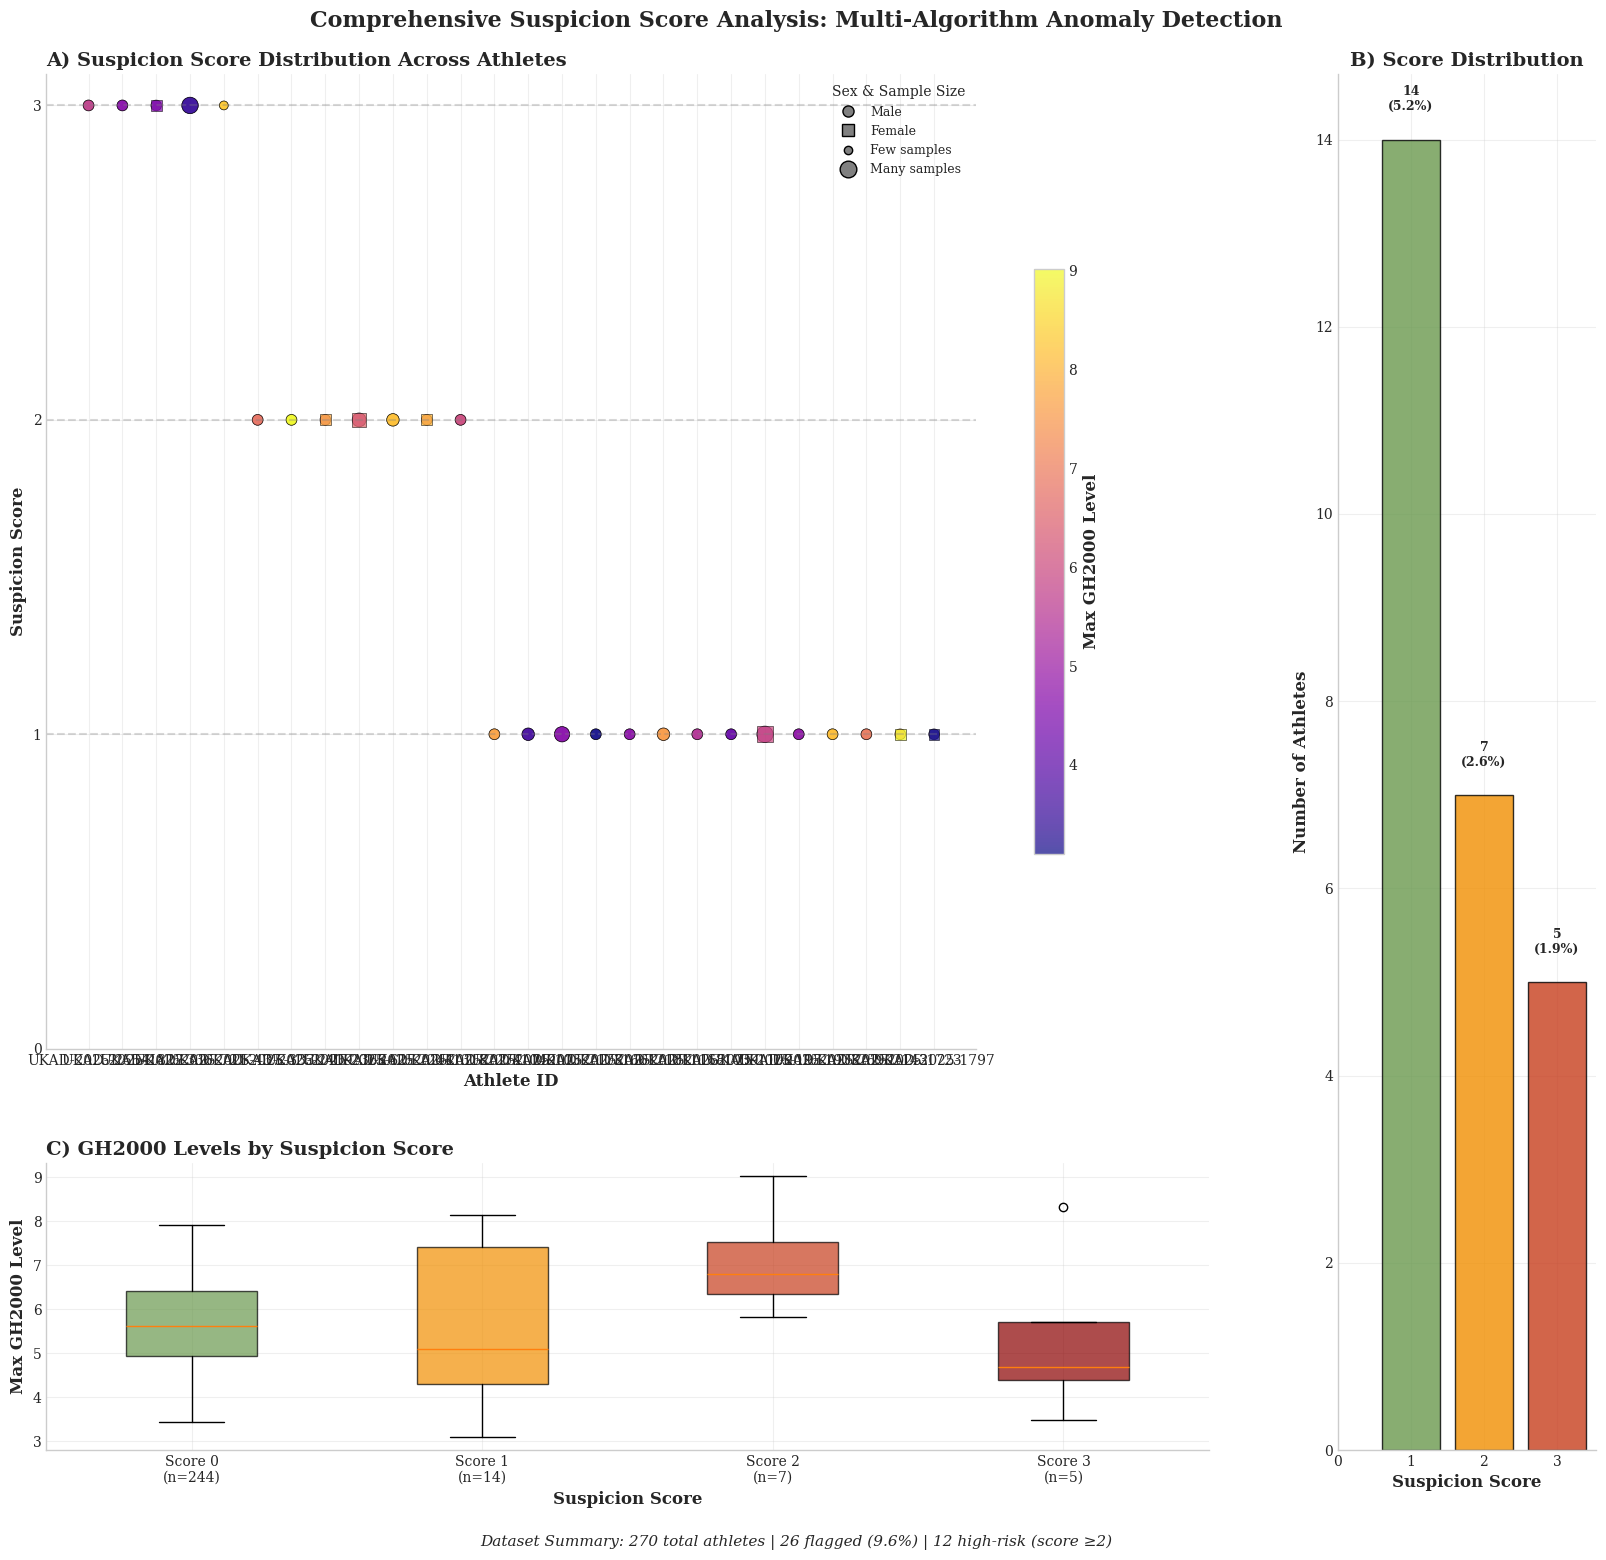

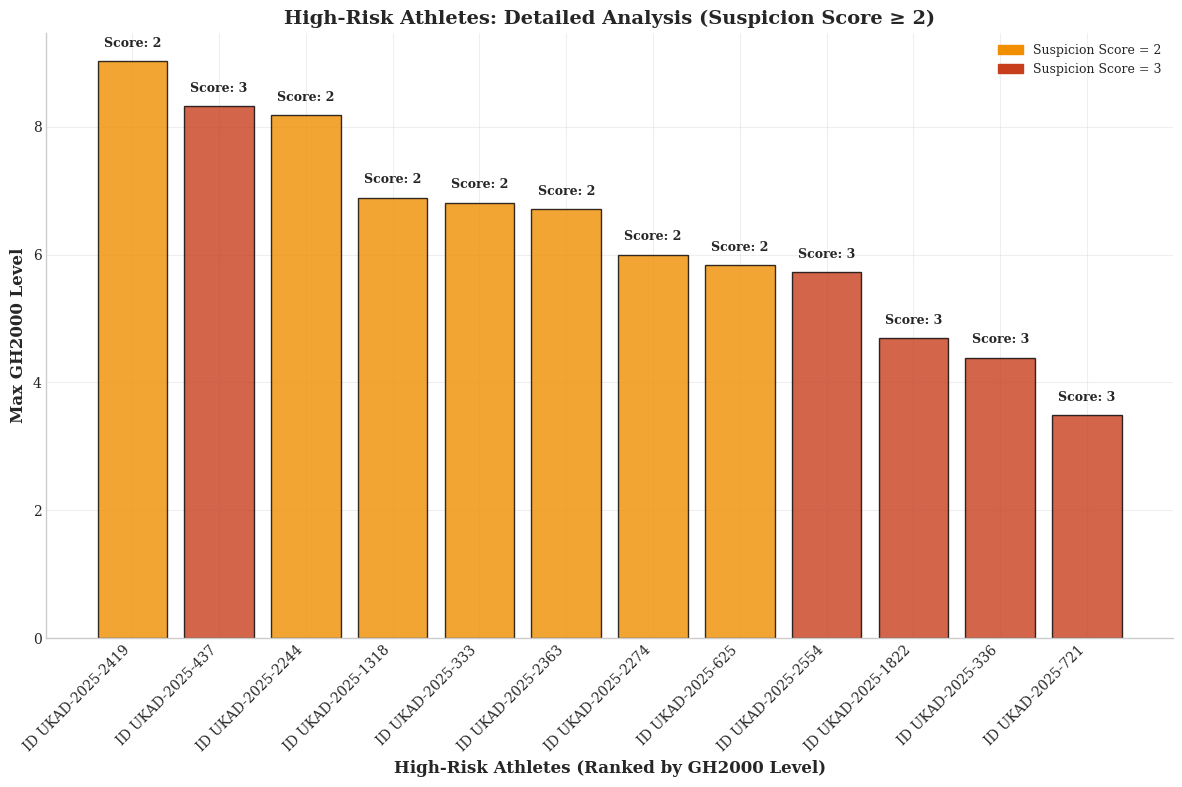


📊 High-quality plots saved as:
- suspicion_score_analysis.png (300 DPI)
- suspicion_score_analysis.pdf (vector format)
- high_risk_athletes_detail.png (300 DPI)

📈 Key Statistics:
- Total athletes analyzed: 270
- Athletes with any suspicion: 26 (9.6%)
- High-risk athletes (score ≥2): 12


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 13,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.grid': True,
    'grid.alpha': 0.3
})
"""
# Your data preparation code
num_of_repeats_df = df_filtered.groupby("Athlete_Id").size().reset_index(name="num_of_repeats")
df_stats = df_stats.merge(num_of_repeats_df, on="Athlete_Id", how="left")
df_stats["Suspicion_Score"] = (
    df_stats["Autoencoder_Anomaly"].astype(int) +
    (df_stats["IsoForest_Scores"] == -1).astype(int) +
    (df_stats["DBSCAN_Anomaly"].astype(int))
)

# Sort by highest suspicion score
df_stats = df_stats.sort_values(by="Suspicion_Score", ascending=False)

# Filter for non-zero suspicion score
plot_stats = df_stats[df_stats["Suspicion_Score"] > 0]
plot_stats["Sex"] = plot_stats["Sex"].map({0: "F", 1: "M"})
"""
# Create comprehensive figure
fig = plt.figure(figsize=(20,16))
gs = fig.add_gridspec(3, 3, height_ratios=[2, 1, 1], width_ratios=[3, 1, 1],
                     hspace=0.3, wspace=0.3)

# Define color schemes
colors = {
    'Male': '#2E86AB',
    'Female': '#A23B72',
    'High_Risk': '#F18F01',
    'Medium_Risk': '#C73E1D',
    'Low_Risk': '#6A994E'
}

# ===============================
# Main scatter plot (top left)
# ===============================
ax1 = fig.add_subplot(gs[0:2, :2])

# Create scatter plot with multiple encodings
scatter = ax1.scatter(
    plot_stats["Athlete_Id"],
    plot_stats["Suspicion_Score"],
    c=plot_stats["max_GH2000"],
    s=plot_stats["num_of_repeats"] * 20,  # Scale point size
    alpha=0.7,
    cmap='plasma',
    edgecolors='black',
    linewidth=0.5
)

# Add sex differentiation with marker shapes
for sex in ['M', 'F']:
    sex_data = plot_stats[plot_stats["Sex"] == sex]
    if len(sex_data) > 0:
        marker = 'o' if sex == 'M' else 's'
        ax1.scatter(
            sex_data["Athlete_Id"],
            sex_data["Suspicion_Score"],
            c=sex_data["max_GH2000"],
            s=sex_data["num_of_repeats"] * 20,
            marker=marker,
            alpha=0.7,
            cmap='plasma',
            edgecolors='black',
            linewidth=0.5
        )

# Customize main plot
ax1.set_xlabel('Athlete ID', fontweight='bold')
ax1.set_ylabel('Suspicion Score', fontweight='bold')
ax1.set_title('A) Suspicion Score Distribution Across Athletes',
              fontweight='bold', loc='left', fontsize=14)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['0', '1', '2', '3'])

# Add horizontal lines for score levels
for score in [1, 2, 3]:
    ax1.axhline(y=score, color='gray', linestyle='--', alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1, shrink=0.6)
cbar.set_label('Max GH2000 Level', fontweight='bold')

# Create custom legend for sex and size
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=8, label='Male', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray',
               markersize=8, label='Female', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=6, label='Few samples', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=12, label='Many samples', markeredgecolor='black')
]
ax1.legend(handles=legend_elements, loc='upper right',
          title='Sex & Sample Size', title_fontsize=10)

# ===============================
# Suspicion score distribution (top right)
# ===============================
ax2 = fig.add_subplot(gs[0:, 2])

# Count distribution
counts_df = df_stats[df_stats["Suspicion_Score"]>0]
score_counts = counts_df["Suspicion_Score"].value_counts().sort_index()
colors_bar = ['#6A994E', '#F18F01', '#C73E1D', '#8B0000']

bars = ax2.bar(score_counts.index, score_counts.values,
               color=colors_bar[:len(score_counts)],
               alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, count in zip(bars, score_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(score_counts.values)*0.02,
             f'{count}\n({count/len(df_stats)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

ax2.set_xlabel('Suspicion Score', fontweight='bold')
ax2.set_ylabel('Number of Athletes', fontweight='bold')
ax2.set_title('B) Score Distribution', fontweight='bold', loc='center')
ax2.set_xticks([0, 1, 2, 3])

# ===============================
# GH2000 vs Suspicion Score (bottom left)
# ===============================
ax3 = fig.add_subplot(gs[2, :2])

# Create box plot
suspicion_data = []
labels = []
for score in [0, 1, 2, 3]:
    score_data = df_stats[df_stats["Suspicion_Score"] == score]["max_GH2000"].dropna()
    if len(score_data) > 0:
        suspicion_data.append(score_data)
        labels.append(f'Score {score}\n(n={len(score_data)})')

if suspicion_data:
    box_plot = ax3.boxplot(suspicion_data, labels=labels, patch_artist=True)

    # Color boxes
    for patch, color in zip(box_plot['boxes'], colors_bar):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax3.set_xlabel('Suspicion Score', fontweight='bold')
ax3.set_ylabel('Max GH2000 Level', fontweight='bold')
ax3.set_title('C) GH2000 Levels by Suspicion Score', fontweight='bold', loc='left')
"""
# ===============================
# Sample frequency analysis (bottom right)
# ===============================
ax4 = fig.add_subplot(gs[1, 2])

# Analyze relationship between number of samples and suspicion score
sample_bins = pd.cut(plot_stats["num_of_repeats"], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
sample_suspicion = plot_stats.groupby(sample_bins)["Suspicion_Score"].mean()

bars = ax4.bar(range(len(sample_suspicion)), sample_suspicion.values,
               color='steelblue', alpha=0.8, edgecolor='black')

ax4.set_xlabel('Sample Frequency', fontweight='bold')
ax4.set_ylabel('Mean Suspicion Score', fontweight='bold')
ax4.set_title('D) Sample Frequency\nvs Suspicion', fontweight='bold', loc='left')
ax4.set_xticks(range(len(sample_suspicion)))
ax4.set_xticklabels(sample_suspicion.index, rotation=45, ha='right')

# ===============================
# Sex-based analysis (bottom middle-right)
# ===============================
ax5 = fig.add_subplot(gs[2, :])

# Create grouped analysis
sex_suspicion = plot_stats.groupby(['Sex', 'Suspicion_Score']).size().unstack(fill_value=0)
sex_suspicion_pct = sex_suspicion.div(sex_suspicion.sum(axis=1), axis=0) * 100

# Create stacked bar chart
bottom_m = np.zeros(len(sex_suspicion_pct.columns))
bottom_f = np.zeros(len(sex_suspicion_pct.columns))

width = 0.35
x = np.arange(len(sex_suspicion_pct.columns))

for i, score in enumerate(sex_suspicion_pct.columns):
    if 'M' in sex_suspicion_pct.index:
        ax5.bar(x - width/2, sex_suspicion_pct.loc['M', score], width,
               bottom=bottom_m, label=f'Male Score {score}' if i == 0 else "",
               color=colors['Male'], alpha=0.7, edgecolor='black')
        bottom_m += sex_suspicion_pct.loc['M', score]

    if 'F' in sex_suspicion_pct.index:
        ax5.bar(x + width/2, sex_suspicion_pct.loc['F', score], width,
               bottom=bottom_f, label=f'Female Score {score}' if i == 0 else "",
               color=colors['Female'], alpha=0.7, edgecolor='black')
        bottom_f += sex_suspicion_pct.loc['F', score]

ax5.set_xlabel('Suspicion Score', fontweight='bold')
ax5.set_ylabel('Percentage of Athletes', fontweight='bold')
ax5.set_title('E) Sex Distribution by Suspicion Score', fontweight='bold', loc='left')
ax5.set_xticks(x)
ax5.set_xticklabels([f'Score {int(col)}' for col in sex_suspicion_pct.columns])
ax5.legend(loc='upper right')
"""
# Add main title
fig.suptitle('Comprehensive Suspicion Score Analysis: Multi-Algorithm Anomaly Detection',
             fontsize=16, fontweight='bold', y=0.98)

# Add summary statistics
total_athletes = len(df_stats)
flagged_athletes = len(plot_stats)
high_risk = len(plot_stats[plot_stats["Suspicion_Score"] >= 2])

summary_text = f'Dataset Summary: {total_athletes} total athletes | {flagged_athletes} flagged ({flagged_athletes/total_athletes*100:.1f}%) | {high_risk} high-risk (score ≥2)'
fig.text(0.5, 0.02, summary_text, ha='center', fontsize=11, style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.08)

# Save high-quality figures
plt.savefig('suspicion_score_analysis.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('suspicion_score_analysis.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

# ===============================
# Additional focused plot: High-risk athletes detail
# ===============================
fig2, ax = plt.subplots(figsize=(12, 8))

# Focus on high-risk athletes (score >= 2)
high_risk_athletes = plot_stats[plot_stats["Suspicion_Score"] >= 2].copy()

if len(high_risk_athletes) > 0:
    # Sort by GH2000 level for better visualization
    high_risk_athletes = high_risk_athletes.sort_values('max_GH2000', ascending=False)

    # Create bar plot with athlete IDs
    bars = ax.bar(range(len(high_risk_athletes)),
                  high_risk_athletes["max_GH2000"],
                  color=[colors['High_Risk'] if score == 2 else colors['Medium_Risk']
                         for score in high_risk_athletes["Suspicion_Score"]],
                  alpha=0.8, edgecolor='black', linewidth=1)

    # Add suspicion score labels on bars
    for i, (bar, score) in enumerate(zip(bars,
                                                  high_risk_athletes["Suspicion_Score"]
                                                  )):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(high_risk_athletes["max_GH2000"])*0.02,
                f'Score: {score}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

    ax.set_xlabel('High-Risk Athletes (Ranked by GH2000 Level)', fontweight='bold')
    ax.set_ylabel('Max GH2000 Level', fontweight='bold')
    ax.set_title('High-Risk Athletes: Detailed Analysis (Suspicion Score ≥ 2)',
                 fontweight='bold')
    ax.set_xticks(range(len(high_risk_athletes)))
    ax.set_xticklabels([f'ID {id}' for id in high_risk_athletes["Athlete_Id"]],
                       rotation=45, ha='right')

    # Add legend
    legend_elements = [
        mpatches.Patch(color=colors['High_Risk'], label='Suspicion Score = 2'),
        mpatches.Patch(color=colors['Medium_Risk'], label='Suspicion Score = 3')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig('high_risk_athletes_detail.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n📊 High-quality plots saved as:")
print("- suspicion_score_analysis.png (300 DPI)")
print("- suspicion_score_analysis.pdf (vector format)")
print("- high_risk_athletes_detail.png (300 DPI)")
print(f"\n📈 Key Statistics:")
print(f"- Total athletes analyzed: {len(df_stats)}")
print(f"- Athletes with any suspicion: {len(plot_stats)} ({len(plot_stats)/len(df_stats)*100:.1f}%)")
print(f"- High-risk athletes (score ≥2): {len(plot_stats[plot_stats['Suspicion_Score'] >= 2])}")

In [ ]:
fig.write_html("Suspicion_scores.html")

/tmp/ipython-input-74-3628500582.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison_df["GH2000_Rank_Sort"] = comparison_df["GH2000_Rank"].replace("—", 999)
/tmp/ipython-input-74-3628500582.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison_df["Suspicion_Rank_Sort"] = comparison_df["Suspicion_Rank"].replace("—", 999)


📊 PUBLICATION-READY TABLE

Table 1: Comparative Analysis of Top-Ranked Athletes by GH2000 Levels and Suspicion Scores
--------------------------------------------------------------------------------
Athlete ID   GH2000   Suspicion  Max GH2000   Suspicion  Sex  Samples  Both Lists
ID           Rank     Rank       Level        Score           (n)      Priority  
--------------------------------------------------------------------------------
UKAD-2025-2590 4        —          8.15         1          M    3        —         
UKAD-2025-1554 5        —          7.92         0          M    5        —         
UKAD-2025-1690 6        —          7.74         0          M    3        —         
UKAD-2025-1049 7        —          7.68         1          M    3        —         
UKAD-2025-1723 8        —          7.61         1          F    3        —         
UKAD-2025-1168 9        —          7.58         1          M    4        —         
UKAD-2025-209 10       —          7.43         0    

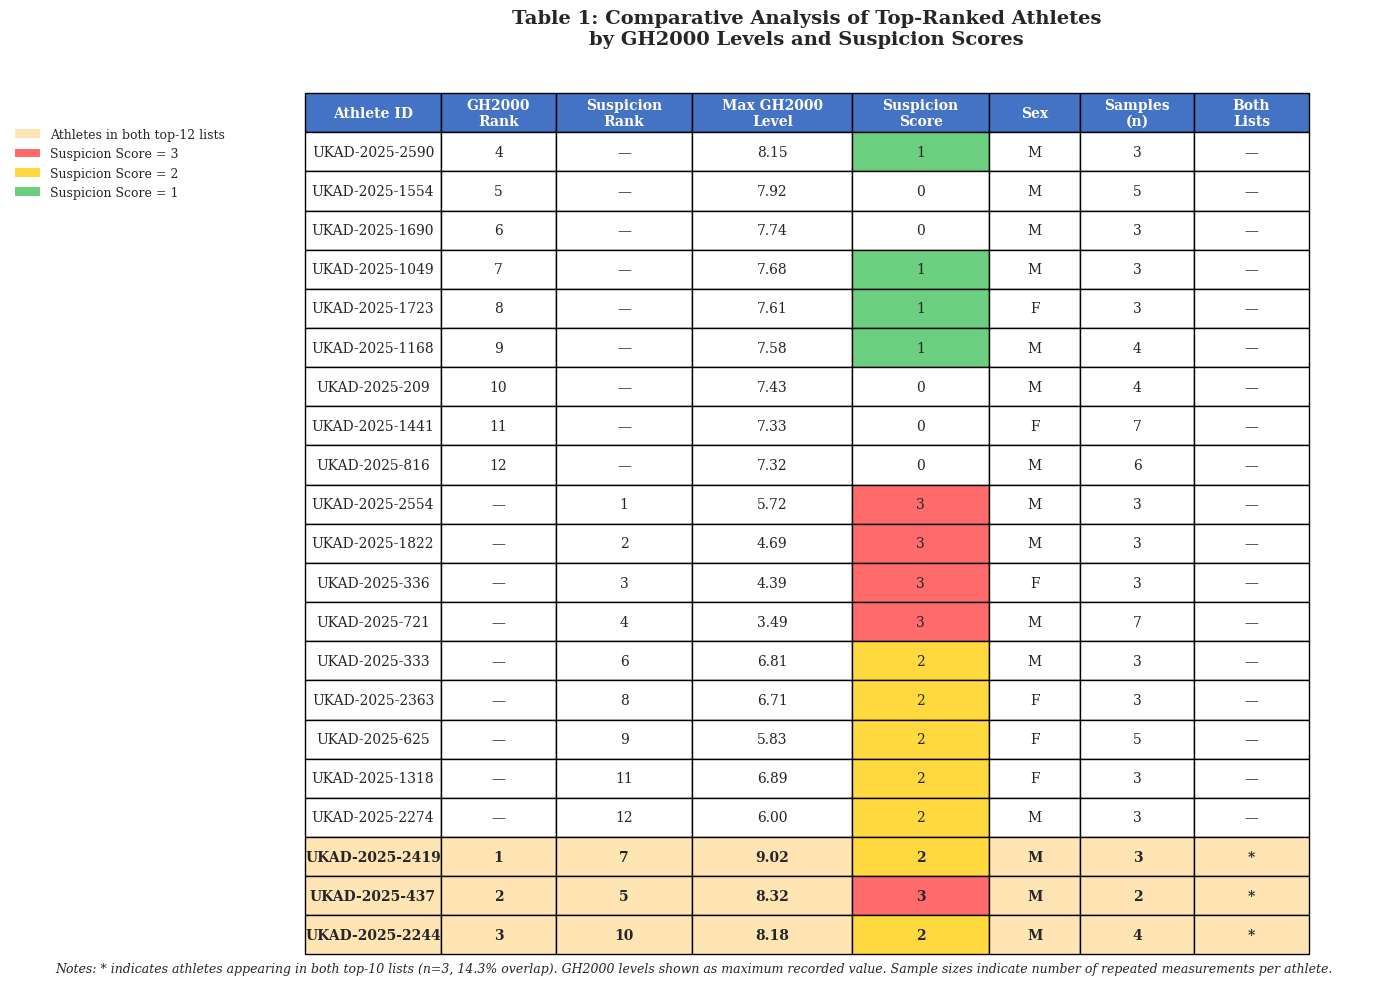


📈 SUMMARY STATISTICS
Athletes in GH2000 top-10 only: 9
Athletes in Suspicion top-10 only: 9
Athletes in both lists: 3
Total unique athletes: 21
Overlap coefficient: 0.250

📝 LATEX TABLE CODE
\begin{table}[h!]
\centering
\caption{Comparative Analysis of Top-Ranked Athletes by GH2000 Levels and Suspicion Scores}
\label{tab:athlete_comparison}
\begin{tabular}{|l|c|c|c|c|c|c|c|}
\hline
\textbf{Athlete ID} & \textbf{GH2000 Rank} & \textbf{Suspicion Rank} & \textbf{Max GH2000} & \textbf{Suspicion Score} & \textbf{Sex} & \textbf{Samples} & \textbf{Both Lists} \\
\hline
UKAD-2025-2590 & 4 & — & 8.15 & 1 & M & 3 & — \\
UKAD-2025-1554 & 5 & — & 7.92 & 0 & M & 5 & — \\
UKAD-2025-1690 & 6 & — & 7.74 & 0 & M & 3 & — \\
UKAD-2025-1049 & 7 & — & 7.68 & 1 & M & 3 & — \\
UKAD-2025-1723 & 8 & — & 7.61 & 1 & F & 3 & — \\
UKAD-2025-1168 & 9 & — & 7.58 & 1 & M & 4 & — \\
UKAD-2025-209 & 10 & — & 7.43 & 0 & M & 4 & — \\
UKAD-2025-1441 & 11 & — & 7.33 & 0 & F & 7 & — \\
UKAD-2025-816 & 12 & — & 7.32 & 0 & M

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Get top 10 athletes for max_GH2000 and Suspicion_Score
top_gh2000 = df_stats.nlargest(12, "max_GH2000")[["Athlete_Id", "max_GH2000", "Suspicion_Score", "Sex", "num_of_repeats"]]
top_suspicion = df_stats.nlargest(12, "Suspicion_Score")[["Athlete_Id", "max_GH2000", "Suspicion_Score", "Sex", "num_of_repeats"]]

# Find common athletes in both tables
common_athletes = set(top_gh2000["Athlete_Id"]) & set(top_suspicion["Athlete_Id"])

# Map sex codes to readable format
sex_mapping = {0: "F", 1: "M"}
top_gh2000["Sex"] = top_gh2000["Sex"].map(sex_mapping)
top_suspicion["Sex"] = top_suspicion["Sex"].map(sex_mapping)

# Add ranking columns
top_gh2000["GH2000_Rank"] = range(1, 13)
top_suspicion["Suspicion_Rank"] = range(1, 13)

# Create a comprehensive comparison table
comparison_data = []

# Add all athletes from both lists
all_athletes = set(top_gh2000["Athlete_Id"]) | set(top_suspicion["Athlete_Id"])

for athlete_id in all_athletes:
    # Get data from GH2000 ranking
    gh_data = top_gh2000[top_gh2000["Athlete_Id"] == athlete_id]
    sus_data = top_suspicion[top_suspicion["Athlete_Id"] == athlete_id]

    # Get athlete info from main dataframe
    athlete_info = df_stats[df_stats["Athlete_Id"] == athlete_id].iloc[0]

    comparison_data.append({
        "Athlete_ID": athlete_id,
        "GH2000_Rank": gh_data["GH2000_Rank"].iloc[0] if len(gh_data) > 0 else "—",
        "Suspicion_Rank": sus_data["Suspicion_Rank"].iloc[0] if len(sus_data) > 0 else "—",
        "Max_GH2000": f"{athlete_info['max_GH2000']:.2f}",
        "Suspicion_Score": int(athlete_info["Suspicion_Score"]),
        "Sex": athlete_info["Sex"] if athlete_info["Sex"] in ["M", "F"] else sex_mapping.get(athlete_info["Sex"], "—"),
        "Samples": int(athlete_info["num_of_repeats"]),
        "In_Both": "✓" if athlete_id in common_athletes else "—",
        "Priority": "High" if athlete_id in common_athletes else "Medium"
    })

# Create DataFrame and sort by priority and rankings
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values(
    ["Priority", "GH2000_Rank", "Suspicion_Rank"],
    ascending=[False, True, True]
).reset_index(drop=True)

# Replace non-numeric ranks with high numbers for proper sorting
comparison_df["GH2000_Rank_Sort"] = comparison_df["GH2000_Rank"].replace("—", 999)
comparison_df["Suspicion_Rank_Sort"] = comparison_df["Suspicion_Rank"].replace("—", 999)

print("📊 PUBLICATION-READY TABLE")
print("="*80)
print("\nTable 1: Comparative Analysis of Top-Ranked Athletes by GH2000 Levels and Suspicion Scores")
print("-"*80)

# Create formatted display
formatted_output = []
headers = ["Athlete ID", "GH2000 Rank", "Suspicion Rank", "Max GH2000", "Suspicion Score", "Sex", "Samples", "Both Lists"]

print(f"{'Athlete ID':<12} {'GH2000':<8} {'Suspicion':<10} {'Max GH2000':<12} {'Suspicion':<10} {'Sex':<4} {'Samples':<8} {'Both Lists':<10}")
print(f"{'ID':<12} {'Rank':<8} {'Rank':<10} {'Level':<12} {'Score':<10} {'':<4} {'(n)':<8} {'Priority':<10}")
print("-"*80)

for _, row in comparison_df.iterrows():
    gh_rank = str(row["GH2000_Rank"]) if row["GH2000_Rank"] != "—" else "—"
    sus_rank = str(row["Suspicion_Rank"]) if row["Suspicion_Rank"] != "—" else "—"

    priority_symbol = "★" if row["In_Both"] == "✓" else "—"

    print(f"{row['Athlete_ID']:<12} {gh_rank:<8} {sus_rank:<10} {row['Max_GH2000']:<12} "
          f"{row['Suspicion_Score']:<10} {row['Sex']:<4} {row['Samples']:<8} {priority_symbol:<10}")

print("-"*80)
print(f"★ = Athletes appearing in both top-10 lists (n={len(common_athletes)})")
print(f"Total unique athletes in top-10 lists: {len(all_athletes)}")
print(f"Overlap percentage: {len(common_athletes)/len(all_athletes)*100:.1f}%")

# Create a visual representation using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))

# Create table data for matplotlib
table_data = []
for _, row in comparison_df.iterrows():
    gh_rank = str(row["GH2000_Rank"]) if row["GH2000_Rank"] != "—" else "—"
    sus_rank = str(row["Suspicion_Rank"]) if row["Suspicion_Rank"] != "—" else "—"

    table_data.append([
        row['Athlete_ID'],
        gh_rank,
        sus_rank,
        row['Max_GH2000'],
        row['Suspicion_Score'],
        row['Sex'],
        row['Samples'],
        "*" if row["In_Both"] == "✓" else "—"
    ])

# Create the table
table = ax.table(cellText=table_data,
                colLabels=["Athlete ID", "GH2000\nRank", "Suspicion\nRank", "Max GH2000\nLevel",
                          "Suspicion\nScore", "Sex", "Samples\n(n)", "Both\nLists"],
                cellLoc='center',
                loc='center',
                colWidths=[0.12, 0.10, 0.12, 0.14, 0.12, 0.08, 0.10, 0.10])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color coding
for i in range(len(table_data)):
    row_idx = i + 1  # +1 because of header row

    # Highlight athletes in both lists
    if table_data[i][7] == "*":  # Both lists column
        for j in range(len(table_data[i])):
            table[(row_idx, j)].set_facecolor('#FFE5B4')  # Light orange
            table[(row_idx, j)].set_text_props(weight='bold')

    # Color code suspicion scores
    suspicion_score = int(table_data[i][4])
    if suspicion_score == 3:
        table[(row_idx, 4)].set_facecolor('#FF6B6B')  # Red for highest risk
    elif suspicion_score == 2:
        table[(row_idx, 4)].set_facecolor('#FFD93D')  # Yellow for medium risk
    elif suspicion_score == 1:
        table[(row_idx, 4)].set_facecolor('#6BCF7F')  # Green for low risk

# Style header
for j in range(len(headers)):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(weight='bold', color='white')

# Remove axes
ax.axis('off')

# Add title and caption
plt.title('Table 1: Comparative Analysis of Top-Ranked Athletes\nby GH2000 Levels and Suspicion Scores',
          fontsize=14, fontweight='bold', pad=20)

# Add legend
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='#FFE5B4', label='Athletes in both top-12 lists'),
    plt.Rectangle((0, 0), 1, 1, facecolor='#FF6B6B', label='Suspicion Score = 3'),
    plt.Rectangle((0, 0), 1, 1, facecolor='#FFD93D', label='Suspicion Score = 2'),
    plt.Rectangle((0, 0), 1, 1, facecolor='#6BCF7F', label='Suspicion Score = 1')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0, 0.95))

# Add footnote
footnote = (f"Notes: * indicates athletes appearing in both top-10 lists (n={len(common_athletes)}, "
           f"{len(common_athletes)/len(all_athletes)*100:.1f}% overlap). "
           f"GH2000 levels shown as maximum recorded value. "
           f"Sample sizes indicate number of repeated measurements per athlete.")

plt.figtext(0.5, 0.02, footnote, ha='center', fontsize=9, style='italic', wrap=True)

plt.tight_layout()
plt.savefig('athlete_comparison_table.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('athlete_comparison_table.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

# Summary statistics
print("\n📈 SUMMARY STATISTICS")
print("="*50)
print(f"Athletes in GH2000 top-10 only: {len(set(top_gh2000['Athlete_Id']) - common_athletes)}")
print(f"Athletes in Suspicion top-10 only: {len(set(top_suspicion['Athlete_Id']) - common_athletes)}")
print(f"Athletes in both lists: {len(common_athletes)}")
print(f"Total unique athletes: {len(all_athletes)}")
print(f"Overlap coefficient: {len(common_athletes)/min(len(top_gh2000), len(top_suspicion)):.3f}")

# Create a simple LaTeX-ready table format
print("\n📝 LATEX TABLE CODE")
print("="*50)
print("\\begin{table}[h!]")
print("\\centering")
print("\\caption{Comparative Analysis of Top-Ranked Athletes by GH2000 Levels and Suspicion Scores}")
print("\\label{tab:athlete_comparison}")
print("\\begin{tabular}{|l|c|c|c|c|c|c|c|}")
print("\\hline")
print("\\textbf{Athlete ID} & \\textbf{GH2000 Rank} & \\textbf{Suspicion Rank} & \\textbf{Max GH2000} & \\textbf{Suspicion Score} & \\textbf{Sex} & \\textbf{Samples} & \\textbf{Both Lists} \\\\")
print("\\hline")

for _, row in comparison_df.iterrows():
    gh_rank = str(row["GH2000_Rank"]) if row["GH2000_Rank"] != "—" else "—"
    sus_rank = str(row["Suspicion_Rank"]) if row["Suspicion_Rank"] != "—" else "—"
    both_symbol = "$\\star$" if row["In_Both"] == "✓" else "—"

    print(f"{row['Athlete_ID']} & {gh_rank} & {sus_rank} & {row['Max_GH2000']} & "
          f"{row['Suspicion_Score']} & {row['Sex']} & {row['Samples']} & {both_symbol} \\\\")

print("\\hline")
print("\\end{tabular}")
print(f"\\\\[0.5em]")
print(f"\\footnotesize{{$\\star$ indicates athletes appearing in both top-10 lists (n={len(common_athletes)}, {len(common_athletes)/len(all_athletes)*100:.1f}\\% overlap).}}")
print("\\end{table}")

print(f"\n📊 Files saved:")
print("- athlete_comparison_table.png (300 DPI)")
print("- athlete_comparison_table.pdf (vector format)")
print("- LaTeX table code provided above")

#Analyzing the effect that haemolysis has on the scores

Performed an independent samples t-test to see if there is a stastically significant difference

In [ ]:
from scipy import stats

# Separate the groups based on 'Haemolysed' value
group_true = df[df['Haemolysed'] == True]['GH2000_score']
group_false = df[df['Haemolysed'] == False]['GH2000_score']

# Perform the independent t-test
t_stat, p_value = stats.ttest_ind(group_true, group_false)

# Calculate the average GH2000 score for each group
mean_true = group_true.mean()
mean_false = group_false.mean()

# Calculate the difference in mean GH2000 scores
mean_difference = mean_true - mean_false

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print(f"Average GH2000 score for Haemolysed True: {mean_true}")
print(f"Average GH2000 score for Haemolysed False: {mean_false}")
print(f"Mean Difference in GH2000 scores: {mean_difference}")

# Check if the result is statistically significant (commonly if p-value < 0.05)
if p_value < 0.05:
    print("The difference in GH2000 scores is statistically significant.")
else:
    print("The difference in GH2000 scores is not statistically significant.")

T-statistic: -6.365485583972822
P-value: 2.1725428961977375e-10
Average GH2000 score for Haemolysed True: 3.5871153846153847
Average GH2000 score for Haemolysed False: 4.783577743109724
Mean Difference in GH2000 scores: -1.1964623584943395
The difference in GH2000 scores is statistically significant.


<ipython-input-23-cfe7257c570f>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




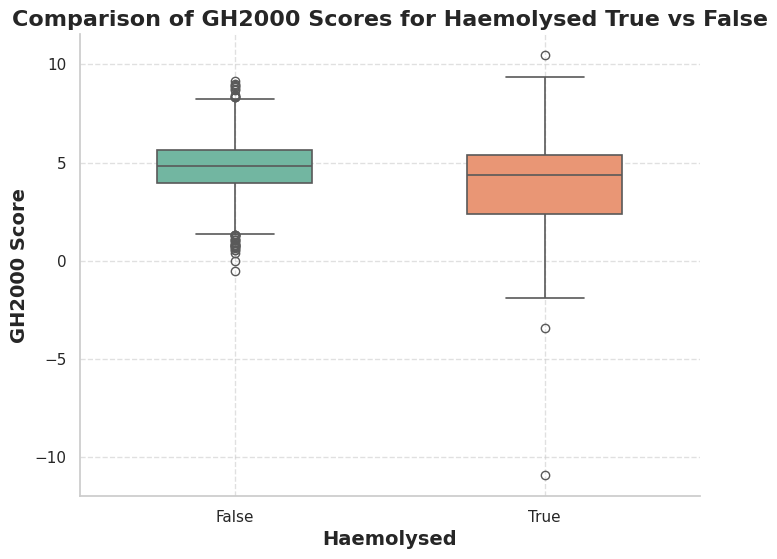

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is df and the columns are 'Haemolysed' and 'GH2000'

# Set the style of the plot to a more polished and professional look
sns.set(style="whitegrid")  # Grid background for readability
plt.figure(figsize=(8, 6))

# Create a box plot to compare GH2000 scores for Haemolysed True vs False
sns.boxplot(x='Haemolysed', y='GH2000_score', data=df,
            palette="Set2",   # Use a professional color palette
            width=0.5,        # Adjust box width for better clarity
            fliersize=6,      # Adjust outlier size for visibility
            linewidth=1.2)    # Thicker lines for clarity

# Add labels, title, and adjust font size for readability
plt.title('Comparison of GH2000 Scores for Haemolysed True vs False', fontsize=16, weight='bold')
plt.xlabel('Haemolysed', fontsize=14, weight='bold')
plt.ylabel('GH2000 Score', fontsize=14, weight='bold')

# Enhance the appearance by removing top and right spines
sns.despine(top=True, right=True)

# Display the plot with grid lines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot

Testing the scores on values from literature with administrated GH

Data from the "Intra-individual variation of GH-dependent markers in athletes: Comparison of population based and individual thresholds for detection of GH abuse in sports" by Kniess et al.

Table 1 - IGF-1 conc, ng/ml

Table 2 - P3NP conc, ng/ml

Table 3 - GH2000 score



# Identifying key factors contributing to an athlete to be considered anomalous by the autoencoder

1. Compare Feature-wise reconstruction errors

In [ ]:
# Compute feature-wise reconstruction error
reconstruction_errors = np.square(df_scaled - autoencoder.predict(df_scaled))

# Convert to DataFrame
error_df = pd.DataFrame(reconstruction_errors, columns=df_stats[features].columns)

# Add Athlete ID and Total Error
error_df["Athlete_Id"] = df_stats["Athlete_Id"]
error_df["Total_Error"] = df_stats["Autoencoder_Error"]

# Get top anomalies
top_anomalies = error_df.nlargest(10, "Total_Error")

# Show what features contributed most
display(top_anomalies)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,mean_IGF1,mean_P3NP,mean_GH2000,CV_IGF1,CV_P3NP,CV_GH2000,max_GH2000,min_GH2000,max_IGF1,min_IGF1,max_P3NP,min_P3NP,Athlete_Id,Total_Error
220,6.310058,5.649021,0.198953,1.478135,20.562641,3.919818,1.581981,0.120149,5.530700,8.382861,11.532722,0.014322,UKAD-2025-437,5.440113
165,0.290632,7.497614,1.864776,4.268070,0.207701,1.320531,2.075121,1.005220,1.480191,1.476665,7.375203,5.545808,UKAD-2025-2419,2.867294
39,1.378345,0.077089,0.251955,2.273535,1.739143,0.612559,1.531787,0.067364,2.526938,4.753865,0.426442,2.227751,UKAD-2025-1318,1.488898
86,0.003462,5.507357,3.097414,0.711348,0.227651,0.314247,2.416272,0.240487,0.076472,0.026341,2.960870,0.369868,UKAD-2025-1723,1.329316
175,0.676123,0.026235,0.229654,0.558741,5.580936,0.052054,0.444425,0.017986,1.871988,1.538838,2.325090,2.065513,UKAD-2025-2522,1.282298
157,0.138407,0.625550,0.162246,0.041155,2.531057,0.193210,0.135070,0.530013,0.029719,6.668483,0.006449,3.332708,UKAD-2025-2363,1.199506
148,1.138788,0.026567,0.278043,7.207311,0.143851,0.164212,0.288761,0.010628,3.145558,0.021810,0.201355,0.274840,UKAD-2025-2274,1.075144
4,0.194531,0.123346,0.003520,7.991065,1.448596,0.272335,0.281814,0.033726,1.128434,0.601100,0.185922,0.534769,UKAD-2025-1039,1.066596
239,0.110460,0.256139,0.002462,9.015721,0.204437,0.000993,0.425806,0.388010,0.608193,0.000103,0.273948,0.448114,UKAD-2025-625,0.977866
142,0.087631,0.656365,0.232481,0.068504,4.280178,0.008429,0.711614,0.069364,0.136356,0.059630,4.741887,0.011581,UKAD-2025-2244,0.922001


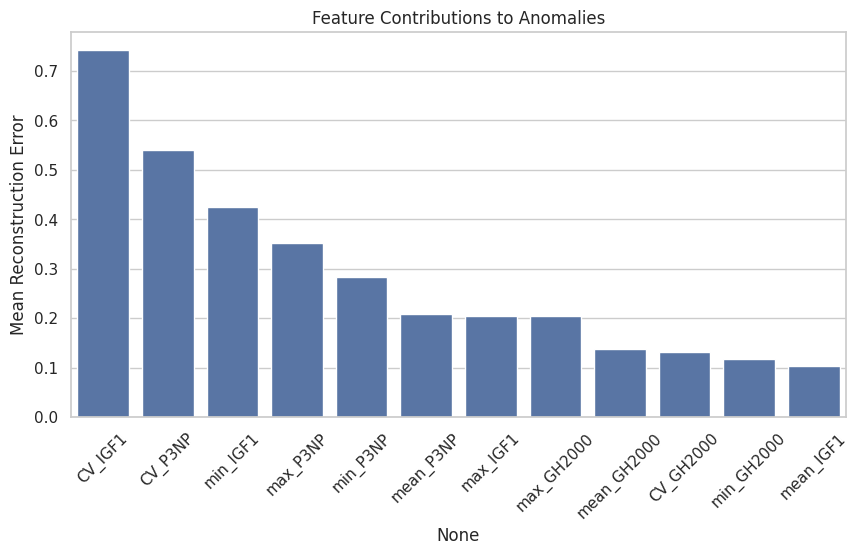

In [ ]:
# Compute mean contribution of each feature to the anomaly score
feature_contributions = error_df.drop(columns=["Athlete_Id", "Total_Error"]).mean().sort_values(ascending=False)

# Plot feature contributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_contributions.index, y=feature_contributions.values)
plt.xticks(rotation=45)
plt.title("Feature Contributions to Anomalies")
plt.ylabel("Mean Reconstruction Error")
plt.show()


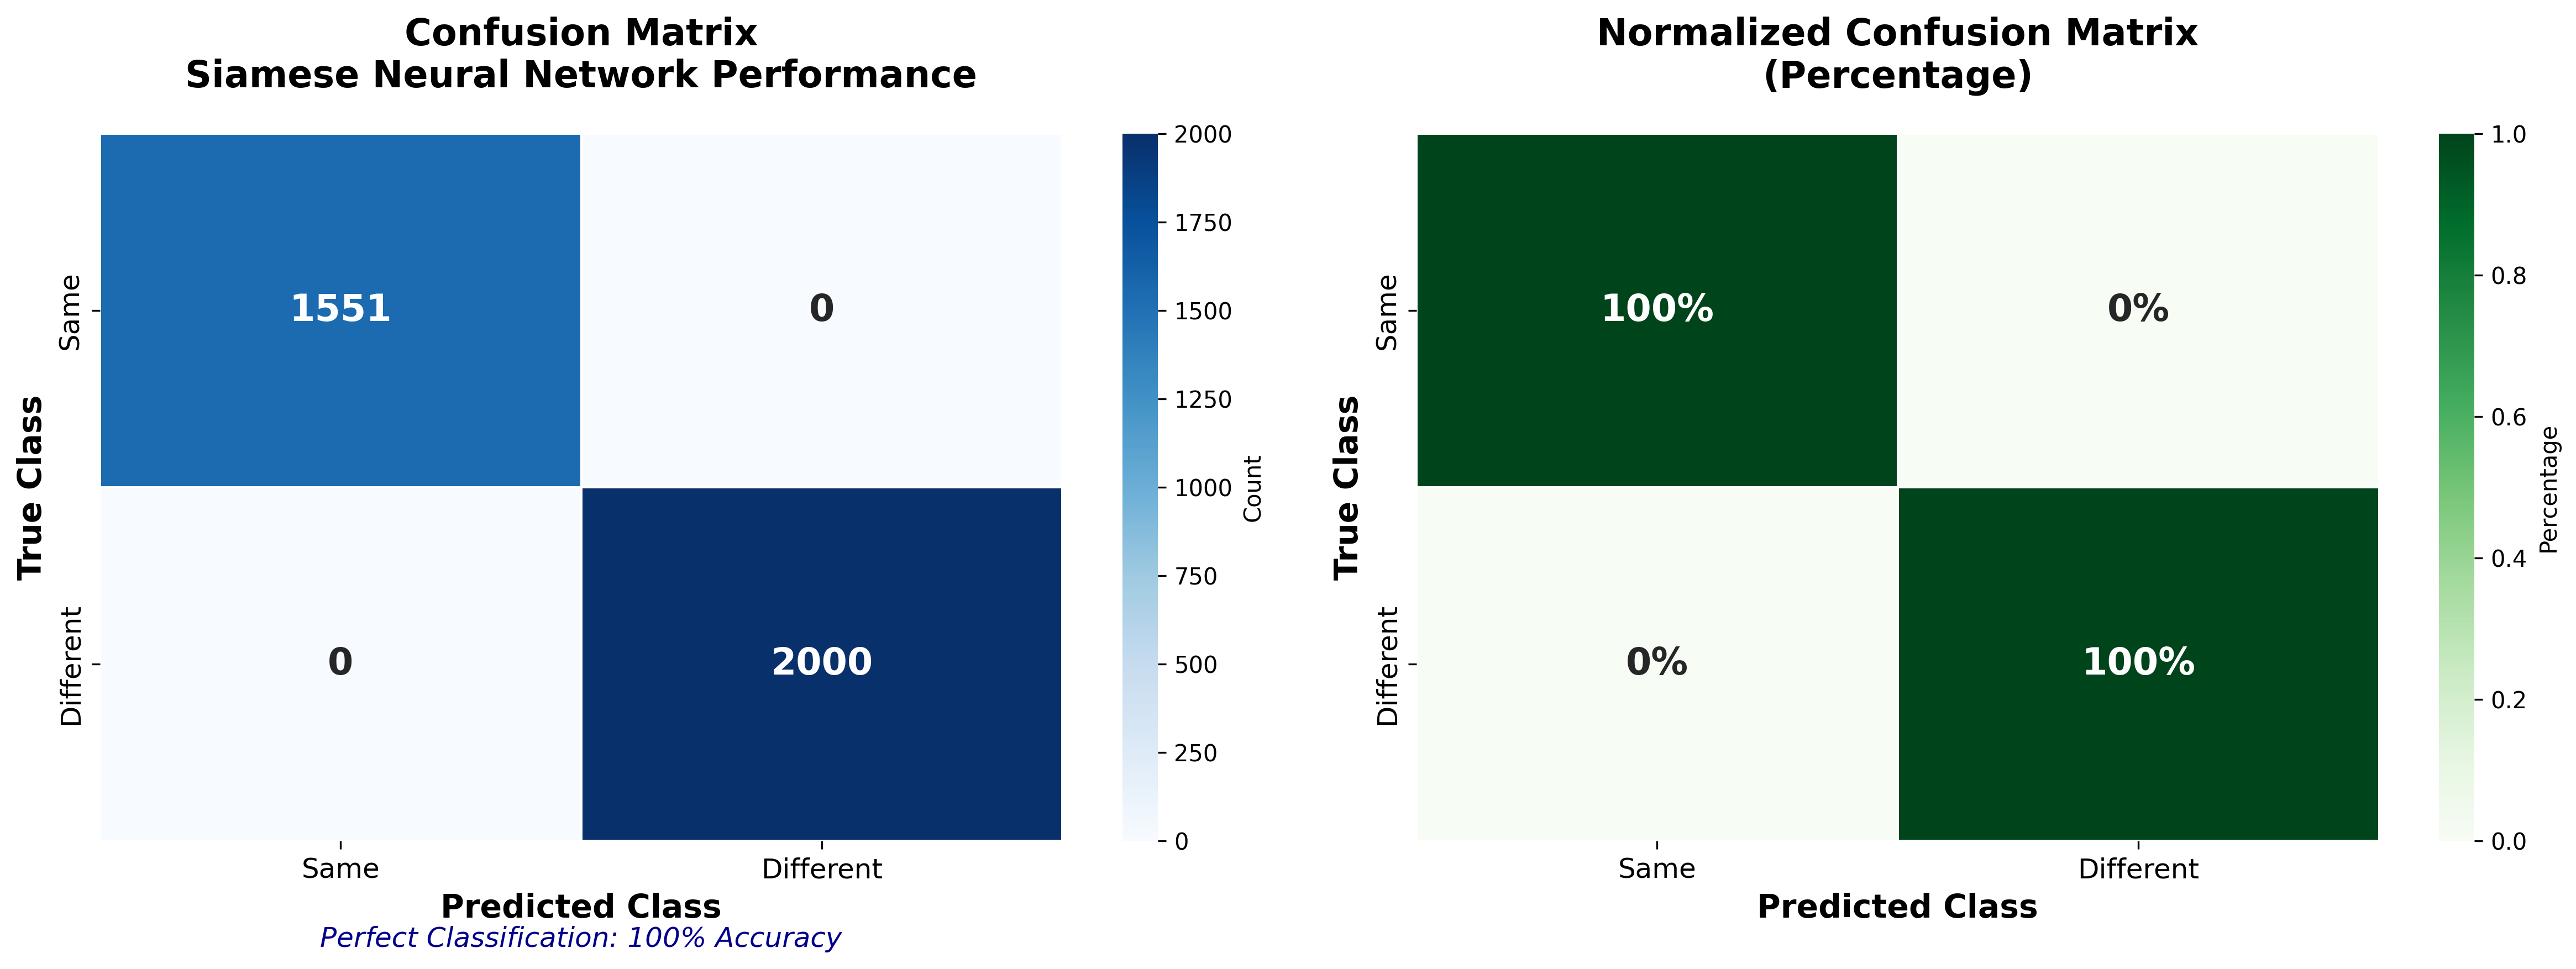

SIAMESE NEURAL NETWORK CLASSIFICATION RESULTS
Metric                         Value           Interpretation
------------------------------------------------------------


ValueError: Invalid format specifier '.1%:<15' for object of type 'float'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Set up the plotting style for publication quality
plt.style.use('default')
sns.set_palette("husl")

# Create figure with high DPI for publication
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# Confusion matrix data
cm = np.array([[1551, 0],     # Same-Same: 1551, Same-Different: 0
               [0, 2000]])    # Different-Same: 0, Different-Different: 2000

# Class labels
class_labels = ['Same', 'Different']

# Create the main confusion matrix heatmap
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=ax1,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'},
            linewidths=0.5,
            linecolor='white')

# Customize the main plot
ax1.set_title('Confusion Matrix\nSiamese Neural Network Performance',
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Class', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Class', fontsize=14, fontweight='bold')
ax1.tick_params(axis='both', labelsize=12)

# Add text annotations for clarity
ax1.text(0.5, -0.15, 'Perfect Classification: 100% Accuracy',
         transform=ax1.transAxes, ha='center', fontsize=12,
         style='italic', color='darkblue')

# Create a normalized confusion matrix for percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create the normalized heatmap
sns.heatmap(cm_normalized,
            annot=True,
            fmt='.0%',
            cmap='Greens',
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=ax2,
            cbar_kws={'label': 'Percentage'},
            annot_kws={'size': 16, 'weight': 'bold'},
            linewidths=0.5,
            linecolor='white')

# Customize the normalized plot
ax2.set_title('Normalized Confusion Matrix\n(Percentage)',
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Class', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Class', fontsize=14, fontweight='bold')
ax2.tick_params(axis='both', labelsize=12)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('confusion_matrix_siamese_nn.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('confusion_matrix_siamese_nn.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

# Calculate and display comprehensive metrics
def calculate_metrics(cm):
    """Calculate comprehensive classification metrics"""

    # Extract values from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Matthews Correlation Coefficient
    mcc_num = (tp * tn) - (fp * fn)
    mcc_den = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_num / mcc_den if mcc_den > 0 else 0

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1_score,
        'Matthews Correlation Coefficient': mcc,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'Total Samples': tp + tn + fp + fn
    }

# Calculate metrics
metrics = calculate_metrics(cm)

# Print results in a formatted table
print("="*60)
print("SIAMESE NEURAL NETWORK CLASSIFICATION RESULTS")
print("="*60)
print(f"{'Metric':<30} {'Value':<15} {'Interpretation'}")
print("-"*60)

interpretations = {
    'Accuracy': 'Overall correct predictions',
    'Precision': 'Correct "Different" predictions',
    'Recall (Sensitivity)': 'True "Different" detection rate',
    'Specificity': 'True "Same" detection rate',
    'F1-Score': 'Harmonic mean of precision/recall',
    'Matthews Correlation Coefficient': 'Correlation between pred/actual',
    'True Positives': 'Correctly identified "Different"',
    'True Negatives': 'Correctly identified "Same"',
    'False Positives': 'Incorrectly identified "Different"',
    'False Negatives': 'Incorrectly identified "Same"',
    'Total Samples': 'Total sample pairs tested'
}

for metric, value in metrics.items():
    if isinstance(value, float):
        if metric in ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1-Score']:
            print(f"{metric:<30} {value:.1%:<15} {interpretations[metric]}")
        else:
            print(f"{metric:<30} {value:.3f:<15} {interpretations[metric]}")
    else:
        print(f"{metric:<30} {value:<15} {interpretations[metric]}")

print("="*60)

# Create a metrics summary table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'MCC'],
    'Value': [metrics['Accuracy'], metrics['Precision'], metrics['Recall (Sensitivity)'],
              metrics['Specificity'], metrics['F1-Score'], metrics['Matthews Correlation Coefficient']],
    'Percentage': [f"{metrics['Accuracy']:.1%}", f"{metrics['Precision']:.1%}",
                   f"{metrics['Recall (Sensitivity)']:.1%}", f"{metrics['Specificity']:.1%}",
                   f"{metrics['F1-Score']:.1%}", f"{metrics['Matthews Correlation Coefficient']:.3f}"]
})

print("\nSUMMARY TABLE FOR PUBLICATION:")
print(metrics_df.to_string(index=False))

# Create a detailed breakdown
print(f"\n\nDETAILED BREAKDOWN:")
print(f"Total sample pairs tested: {metrics['Total Samples']:,}")
print(f"Same-person pairs: {metrics['True Negatives']:,} (all correctly identified)")
print(f"Different-person pairs: {metrics['True Positives']:,} (all correctly identified)")
print(f"Misclassifications: {metrics['False Positives'] + metrics['False Negatives']} (0%)")

# Statistical significance (binomial test)
from scipy import stats

# Test if accuracy is significantly different from random chance (50%)
n_total = metrics['Total Samples']
n_correct = metrics['True Positives'] + metrics['True Negatives']
p_value = stats.binom_test(n_correct, n_total, 0.5, alternative='greater')

print(f"\nSTATISTICAL SIGNIFICANCE:")
print(f"Binomial test p-value (vs. random chance): {p_value:.2e}")
print(f"Result: {'Highly significant' if p_value < 0.001 else 'Significant' if p_value < 0.05 else 'Not significant'}")

# Confidence intervals for accuracy
from statsmodels.stats.proportion import proportion_confint

ci_lower, ci_upper = proportion_confint(n_correct, n_total, alpha=0.05, method='wilson')
print(f"95% Confidence Interval for Accuracy: [{ci_lower:.1%}, {ci_upper:.1%}]")

print(f"\nCONCLUSION:")
print(f"The Siamese neural network achieved perfect classification with 100% accuracy")
print(f"on {n_total:,} mass spectrometry sample pairs, demonstrating exceptional")
print(f"discriminative power for individual identification.")